## 猜词游戏


In [1]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simsun",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import *
from io import StringIO
import nltk

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

**问题3:开发并总结一个模型来按难度对解决方案单词进行分类。识别与每个分类关联的给定词的属性。使用您的模型，EERIE这个词有多难？讨论分类模型的准确性。**

解决方案：无监督的聚类模型，可以使用多种不同的特征对数据进行聚类分析，使用的聚类分析方法也有多种选择。

使用的特征可以有：

（1）第2问预测出的几次可以预测出的百分比；

（2）第一问预测出的提交情况（该特征可能并不是很好用）；

（3）字母的出现情况特征；

常用的聚类算法有：

K均值聚类、密度聚类、模糊聚类等

可以结合数据降维算法进行聚类效果的可视化分析，常用方法有：主成分分析、TSNE降维等。

### 下面使用的特征主要是   第2问预测出的几次可以预测出的百分比+字母的出现情况特征

## 数据准备

In [2]:
## 导入数据
df = pd.read_excel("Problem_C_Data_Wordle_clean_all.xlsx",date_parser=["Date"])
df = df.sort_values(by = "Date").reset_index(drop = True)
df

,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,tries1,tries2,tries3,tries4,tries5,tries6,triesX,word1,word2,word3,word4,word5,Tag
0,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1,s,l,u,m,p,NN
1,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,c,r,a,n,k,NN
2,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,g,o,r,g,e,NN
3,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,q,u,e,r,y,JJ
4,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,d,r,i,n,k,VB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,c,o,n,d,o,NN
355,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,i,m,p,e,l,NN
356,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,h,a,v,o,c,NN
357,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,m,o,l,a,r,JJ


In [3]:
df.columns

Index(['Date', 'Contest_number', 'Word', 'Number_of_reported_results',
       'Number_in_hard_mode', 'tries1', 'tries2', 'tries3', 'tries4', 'tries5',
       'tries6', 'triesX', 'word1', 'word2', 'word3', 'word4', 'word5', 'Tag'],
      dtype='object')

# 模式1:根据尝试次数的数据分布进行聚类

In [4]:
## 对数据进行特征工程预处理准备工作
df2 = df[["tries1","tries2","tries3","tries4","tries5","tries6","triesX",
          'word1', 'word2', 'word3', 'word4', 'word5', 'Tag']]
df2["Tag"][~((df2["Tag"] == "NN") | (df2["Tag"] == "JJ"))] = "Other"
df2

,tries1,tries2,tries3,tries4,tries5,tries6,triesX,word1,word2,word3,word4,word5,Tag
0,1,3,23,39,24,9,1,s,l,u,m,p,NN
1,1,5,23,31,24,14,2,c,r,a,n,k,NN
2,1,3,13,27,30,22,4,g,o,r,g,e,NN
3,1,4,16,30,30,17,2,q,u,e,r,y,JJ
4,1,9,35,34,16,5,1,d,r,i,n,k,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0,2,17,35,29,14,3,c,o,n,d,o,NN
355,0,3,21,40,25,9,1,i,m,p,e,l,NN
356,0,2,16,38,30,12,2,h,a,v,o,c,NN
357,0,4,21,38,26,9,1,m,o,l,a,r,JJ


findfont: Font family ['simsun'] not found. Falling back to DejaVu Sans.
findfont: Font family ['simsun'] not found. Falling back to DejaVu Sans.


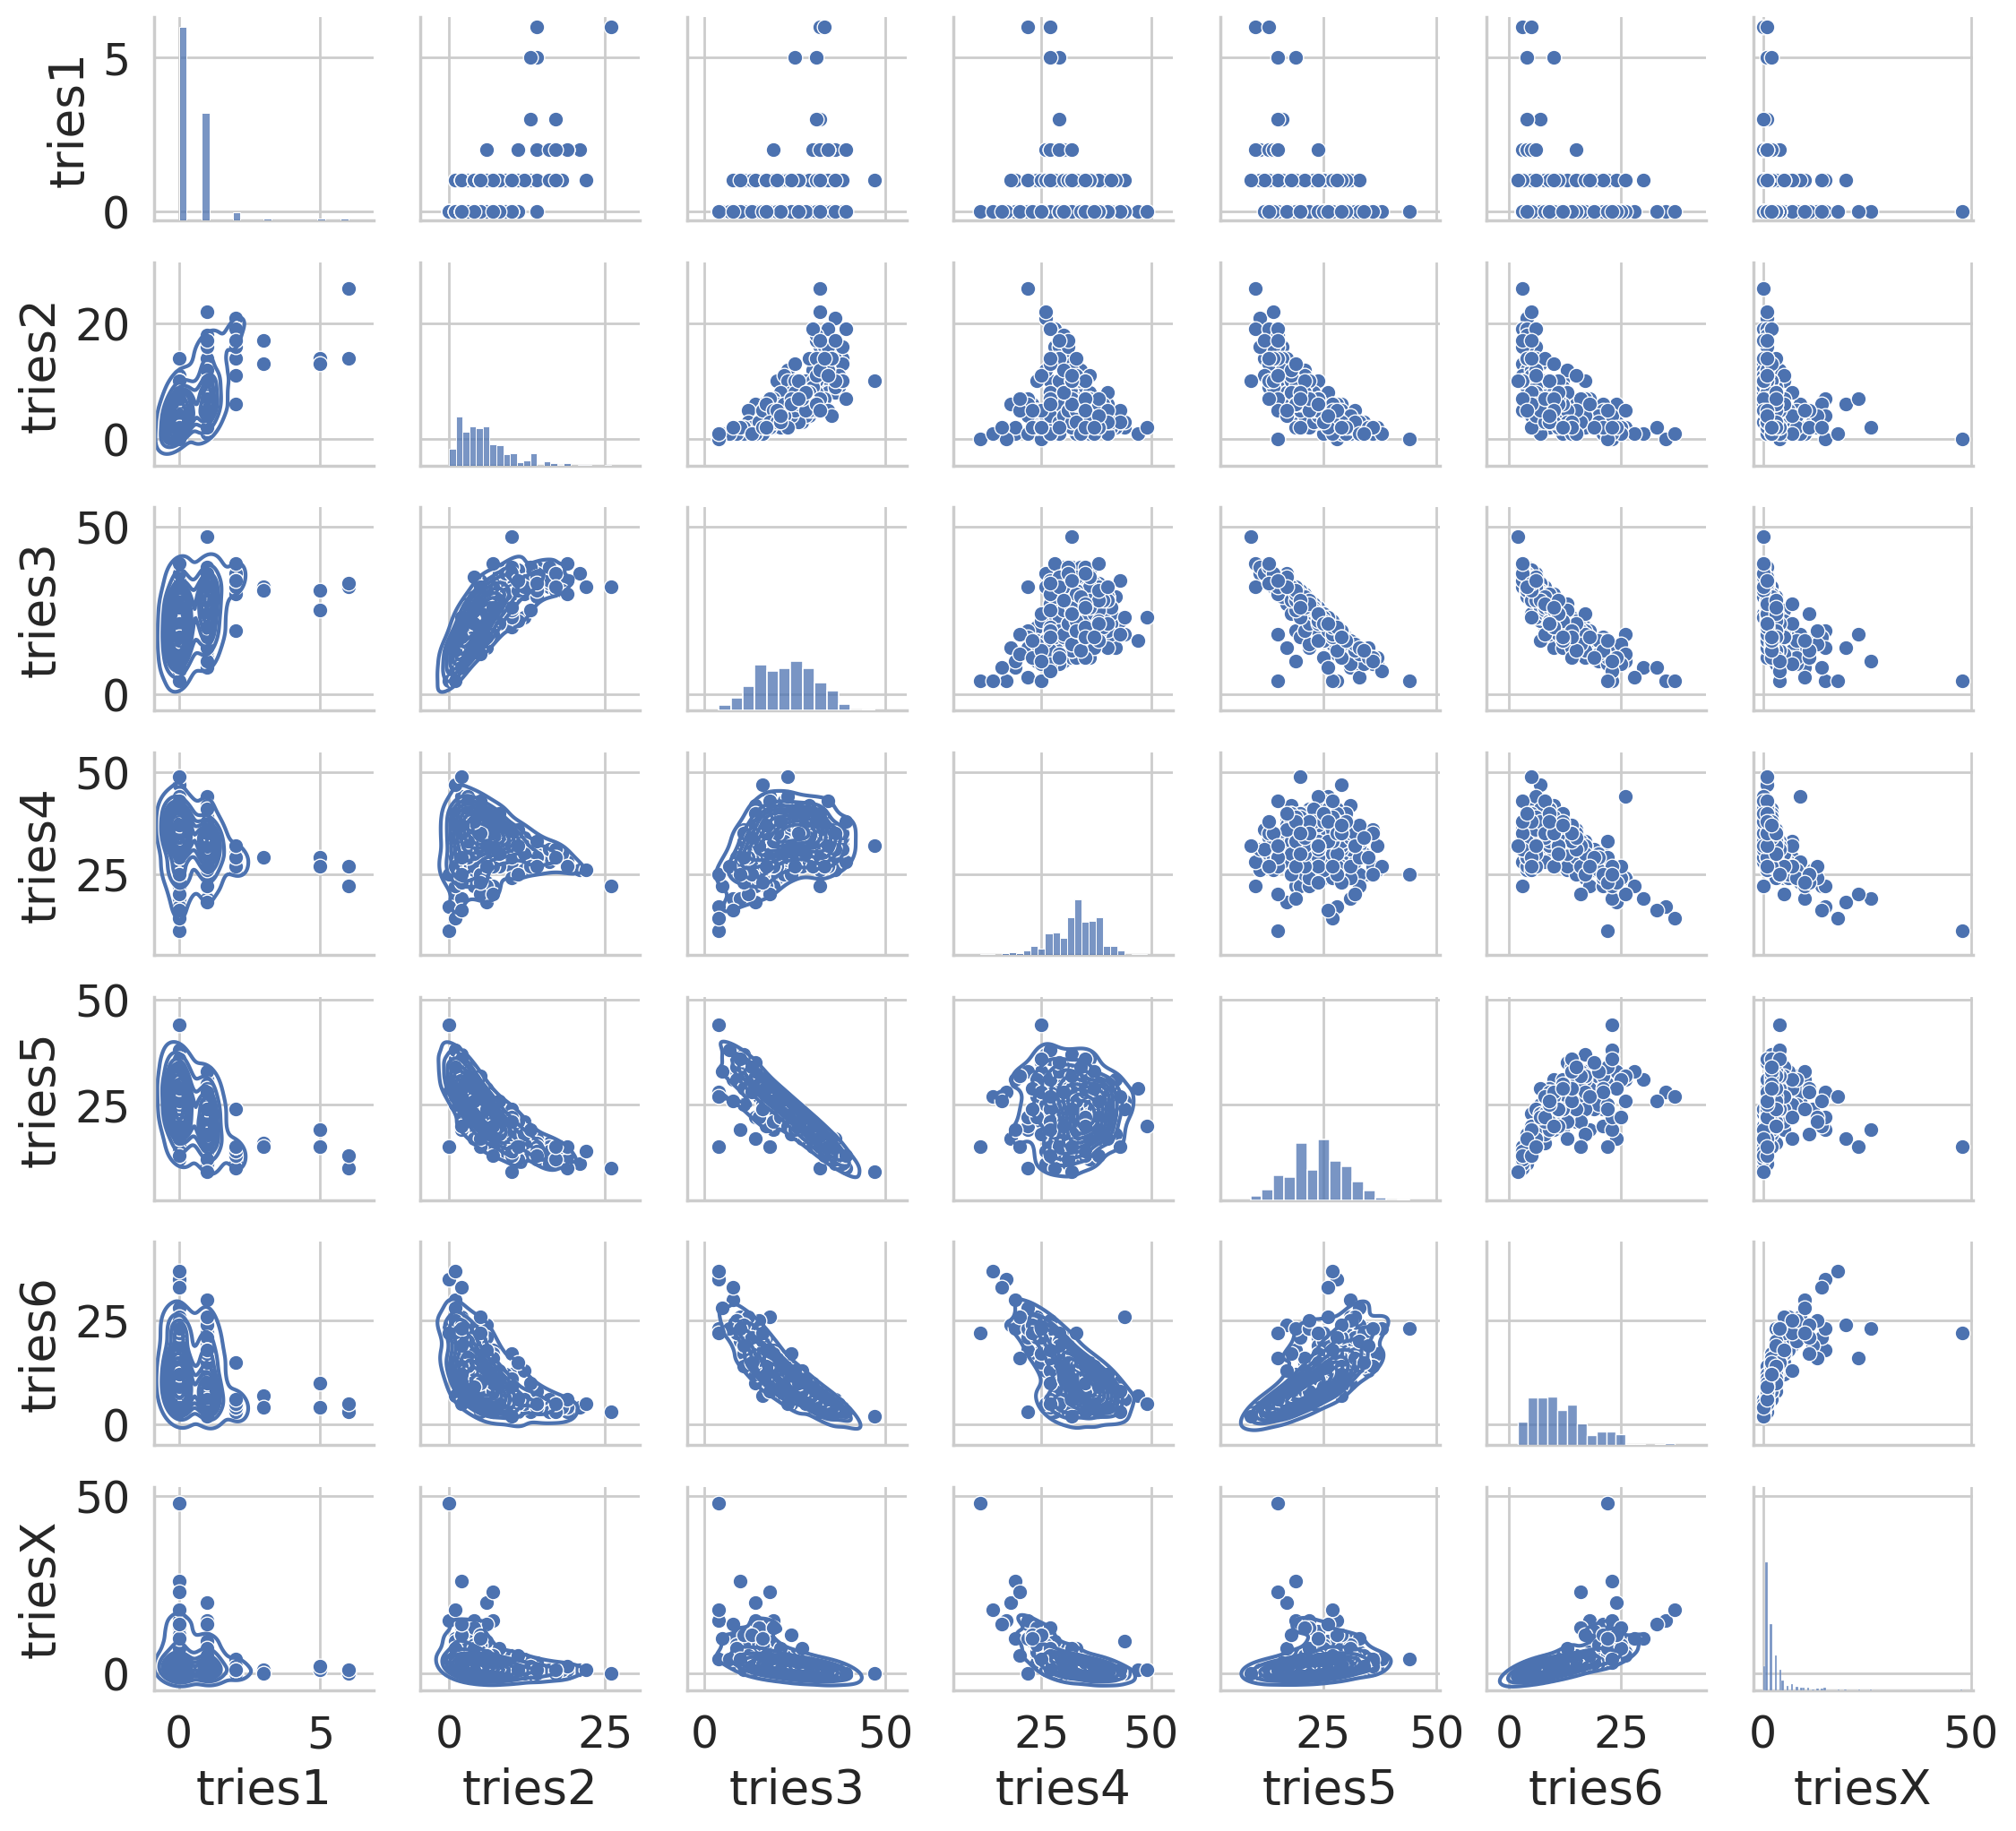

In [5]:
# ## 可视化数据的矩阵散点图，观察数据分布情况
p = sns.pairplot(df2, height=1.5,aspect=1.1) 
p.map_lower(sns.kdeplot, levels=10) 

In [6]:
## 数据标准化与处理
ss = StandardScaler()
## 对字母变了进行编码
letter = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
          'p','q','r','s','t','u','v','w','x','y','z']
le1 = LabelEncoder()
le1.fit(letter)
le2 = LabelEncoder()
le2.fit(["NN","JJ","Other"])
le2

LabelEncoder()

In [7]:
## 对字母进行编码
df2["word1"] = le1.transform(df2["word1"])
df2["word2"] = le1.transform(df2["word2"])
df2["word3"] = le1.transform(df2["word3"])
df2["word4"] = le1.transform(df2["word4"])
df2["word5"] = le1.transform(df2["word5"])
df2["Tag"] = le2.transform(df2["Tag"])
df2

,tries1,tries2,tries3,tries4,tries5,tries6,triesX,word1,word2,word3,word4,word5,Tag
0,1,3,23,39,24,9,1,18,11,20,12,15,1
1,1,5,23,31,24,14,2,2,17,0,13,10,1
2,1,3,13,27,30,22,4,6,14,17,6,4,1
3,1,4,16,30,30,17,2,16,20,4,17,24,0
4,1,9,35,34,16,5,1,3,17,8,13,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0,2,17,35,29,14,3,2,14,13,3,14,1
355,0,3,21,40,25,9,1,8,12,15,4,11,1
356,0,2,16,38,30,12,2,7,0,21,14,2,1
357,0,4,21,38,26,9,1,12,14,11,0,17,0


In [8]:
# ## 准话为数据表
# df2SSdf = pd.DataFrame(data=df2SS,columns=df2.columns.values)
# df2SSdf

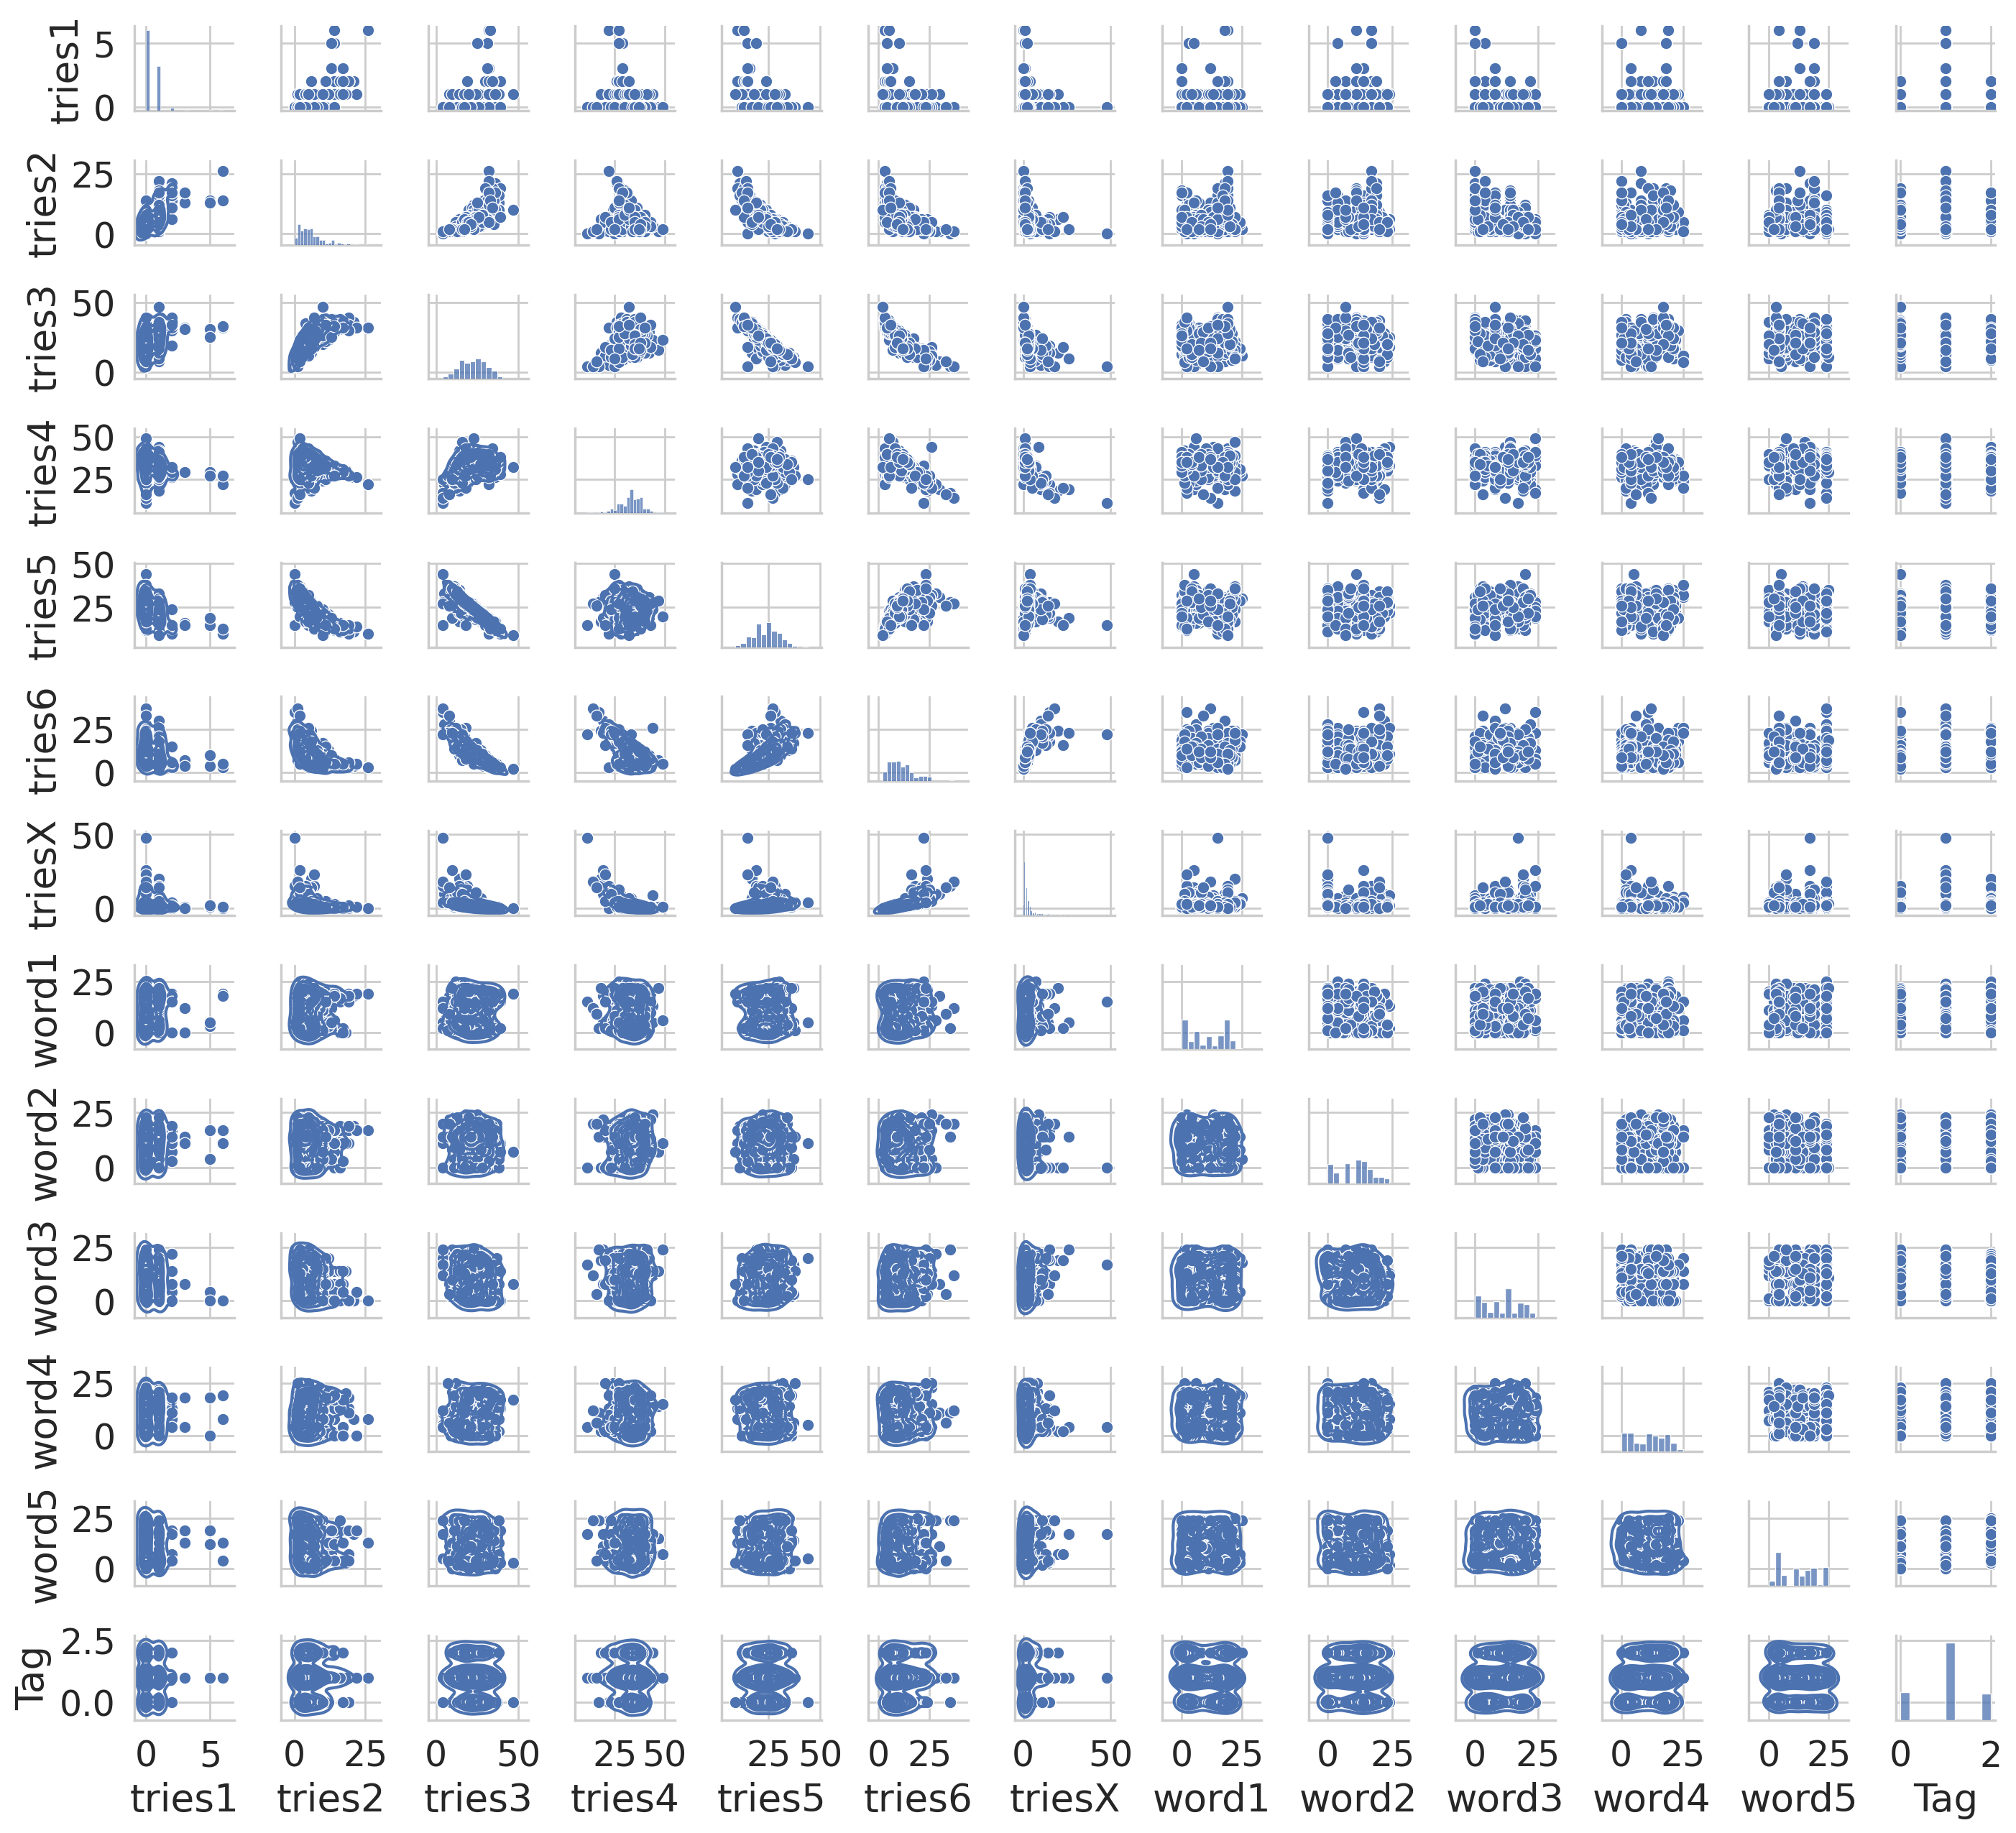

In [9]:
## 可视化数据的矩阵散点图，观察数据分布情况
p = sns.pairplot(df2, height=1,aspect=1.1) 
p.map_lower(sns.kdeplot, levels=8) 
plt.show()

In [10]:
le1.transform(["e","e","r","i","e"])


array([ 4,  4, 17,  8,  4])

In [11]:
np.array([1, 5, 17, 32, 27, 12, 3])

array([ 1,  5, 17, 32, 27, 12,  3])

In [12]:
np.concatenate((np.array([1, 5, 17, 32, 27, 12, 3]),le1.transform(["e","e","r","i","e"])))

array([ 1,  5, 17, 32, 27, 12,  3,  4,  4, 17,  8,  4])

In [13]:
## 对待预测数据的特征进行处理
## (1, 2, 3,  4, 5,  6, X) 的相关百分比预测值分别为：
## (1, 5, 17, 32, 27, 12, 3)
X_test =  np.concatenate((np.array([1, 5, 17, 32, 27, 12, 3]),
                          le1.transform(["e","e","r","i","e"]),
                          le2.transform(["NN"]))).reshape((1,-1))
X_test

array([[ 1,  5, 17, 32, 27, 12,  3,  4,  4, 17,  8,  4,  1]])

In [14]:
X_test.shape

(1, 13)

In [15]:
## 数据标准化操作
df2SS = ss.fit_transform(df2)
df2SS.shape

(359, 13)

In [16]:
X_test_SS = ss.transform(X_test)
X_test_SS

array([[ 0.67693289, -0.20733077, -0.73704474, -0.17349163,  0.56614455,
         0.07099986,  0.04737128, -0.89833468, -1.045363  ,  0.90992887,
        -0.40615338, -1.09538842,  0.02177043]])

## 对数据特征先进行降维后数据可视化

In [17]:
df2.shape

(359, 13)

In [18]:
## 数据降维主成分分析
pca = PCA(n_components = 13, random_state = 123) 
df2SS_pca = pca.fit_transform(df2SS)
print(df2SS_pca.shape)

(359, 13)


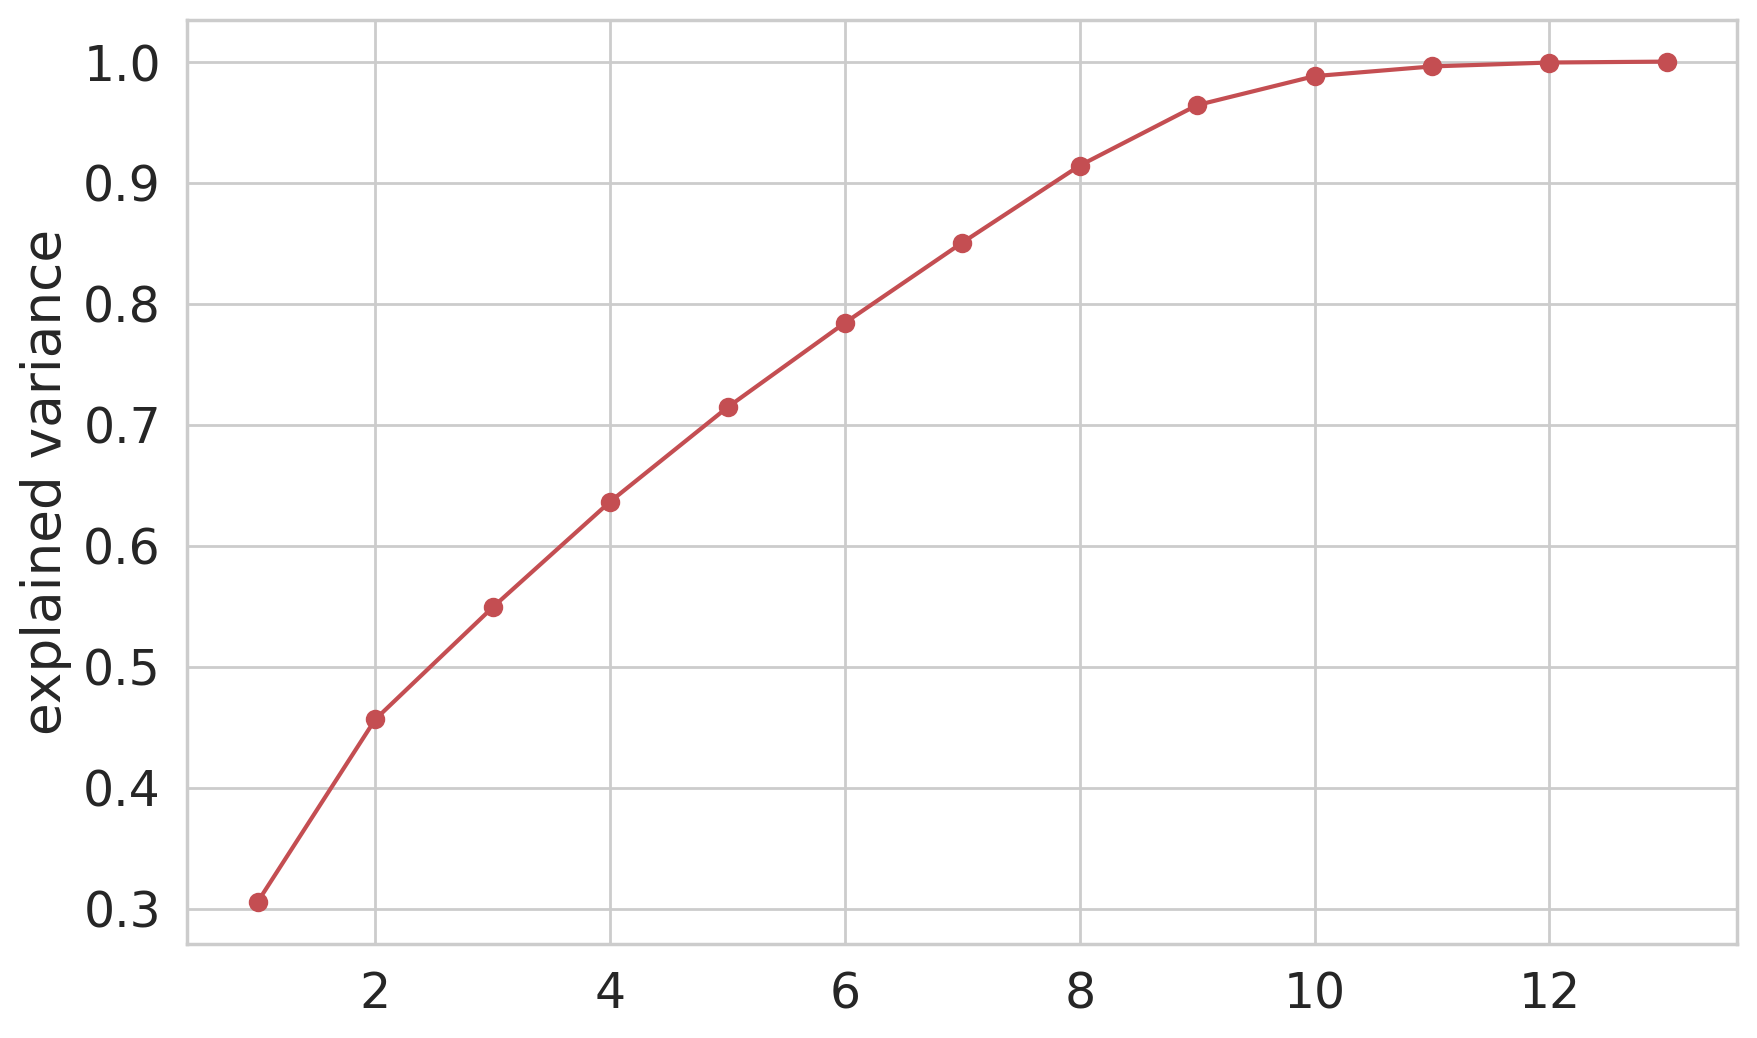

In [19]:
## 可视化分析每个主成分的解释方差
x = np.arange(df2SS_pca.shape[1])+1
plt.figure(figsize=(10,6))
plt.plot(x,np.cumsum(pca.explained_variance_ratio_),"r-o")
plt.xlabel("")
plt.ylabel("explained variance")
plt.title("")
plt.show()

## 可保留2个或者3个主成分

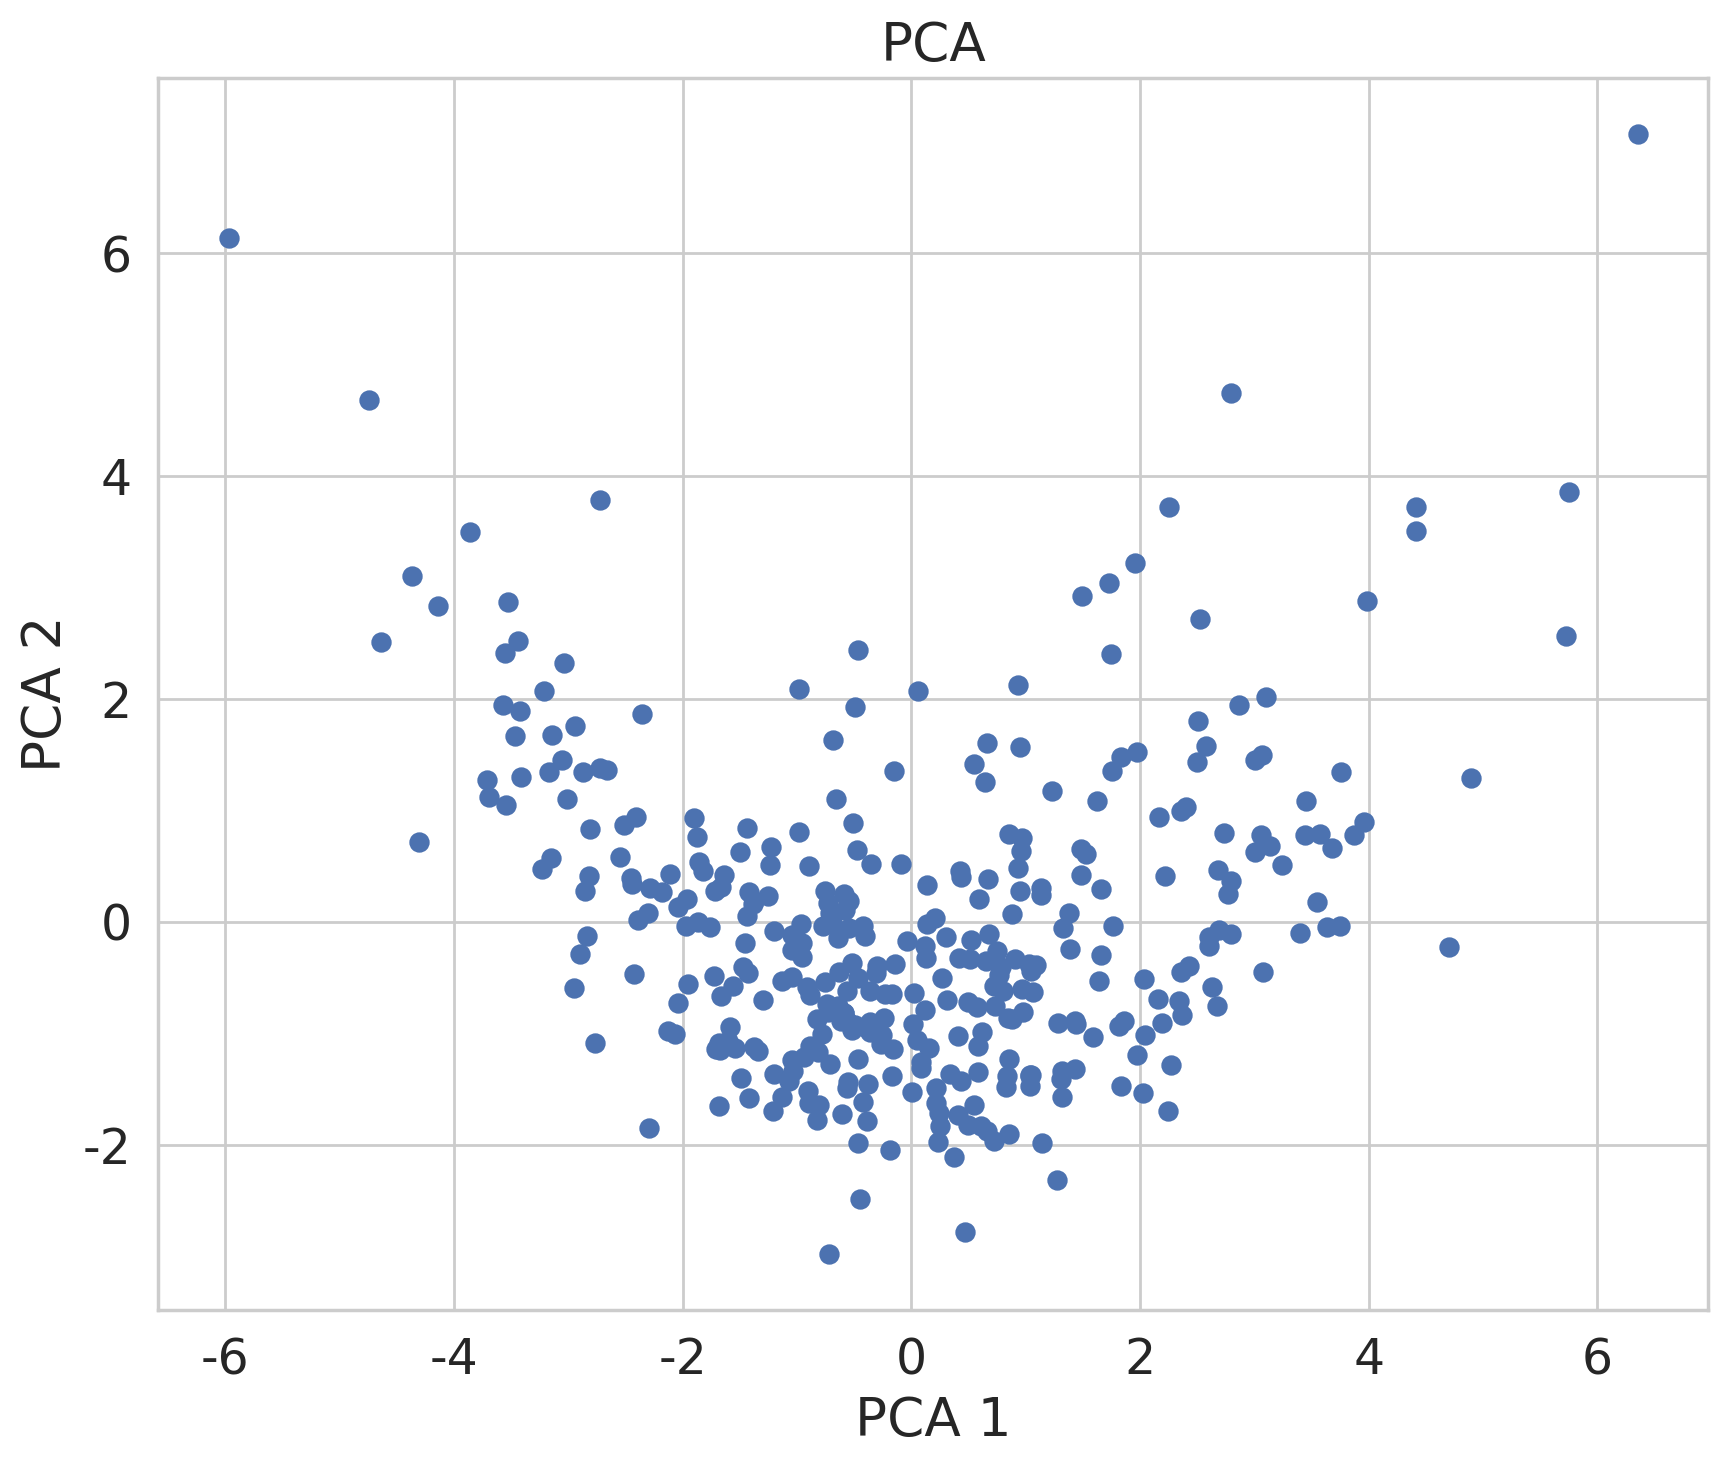

In [20]:
## 2个主成分数据可视化
X = df2SS_pca[:,0]
Y = df2SS_pca[:,1]
## 可视化
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1) 
ax.scatter(X,Y,s = 40,alpha = 1)  
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.title("PCA")
plt.show()

In [21]:
# ## 3个主成分数据可视化
# X = df2SS_pca[:,0]
# Y = df2SS_pca[:,1]
# Z = df2SS_pca[:,2]
# ## 可视化
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1,1,1,projection="3d") 
# ax.view_init(azim=-45, elev= 30)
# ax.scatter3D(X,Y,Z,s = 40,alpha = 1)  
# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
# ax.set_zlabel("PCA 3")
# plt.title("PCA")
# plt.show()

(359, 2)


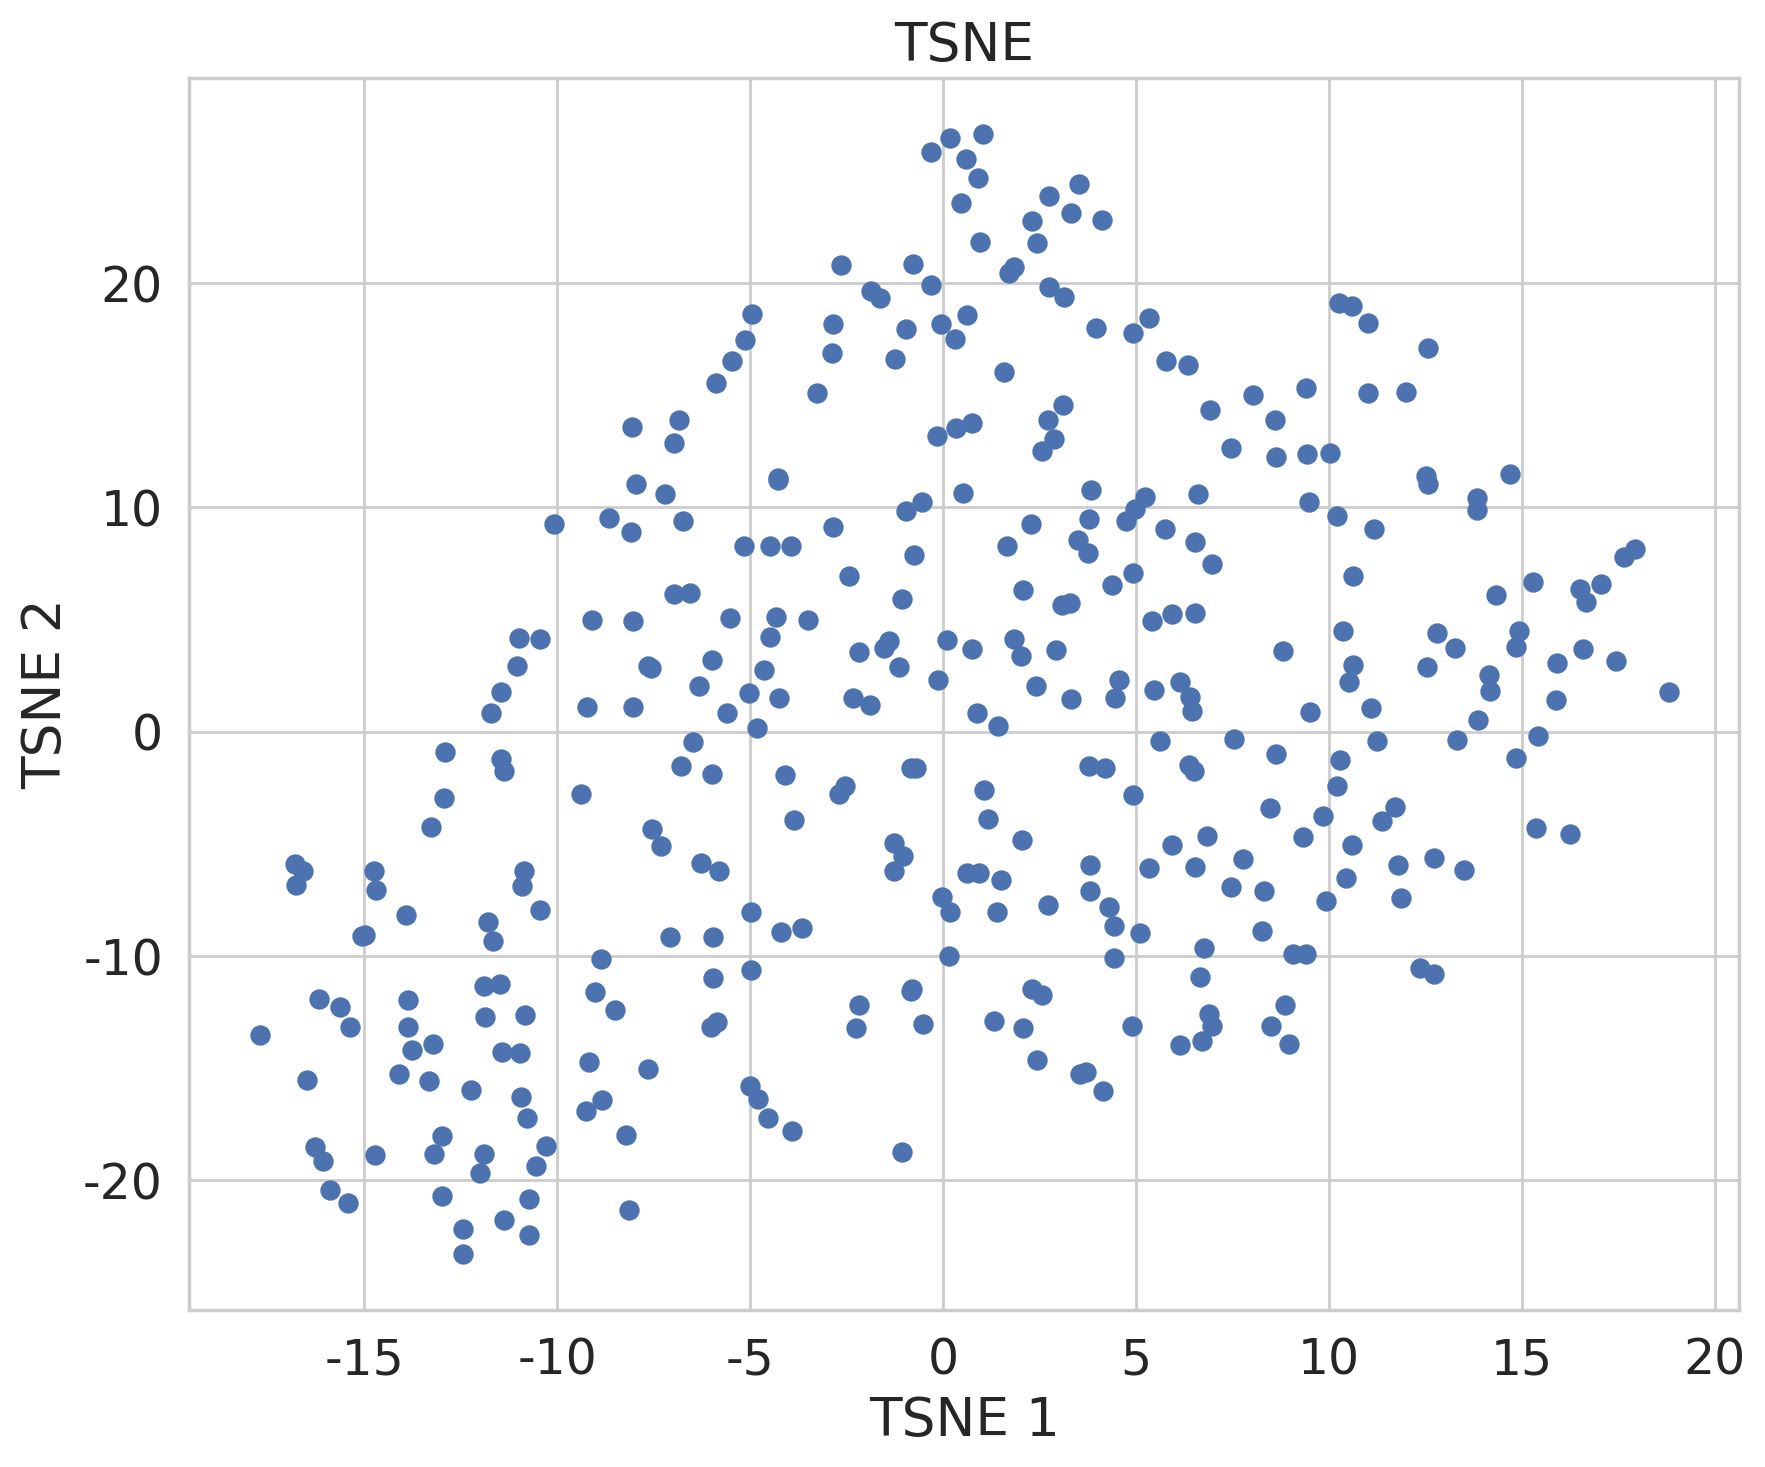

In [22]:
## TSNE降维
tsne = TSNE(n_components=2,random_state=12) 
df2SS_tsne = tsne.fit_transform(df2SS)
print(df2SS_tsne.shape)

## 可视化
X = df2SS_tsne[:,0]
Y = df2SS_tsne[:,1]
## 可视化
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1) 
ax.scatter(X,Y,s = 40,alpha = 1)  
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.title("TSNE")
plt.show()

In [23]:
# ## TSNE降维，降到3维
# tsne = TSNE(n_components=3,random_state=123) 
# df2SS_tsne3 = tsne.fit_transform(df2SS)
# print(df2SS_tsne3.shape)

# ## 可视化
# X = df2SS_tsne3[:,0]
# Y = df2SS_tsne3[:,1]
# Z = df2SS_tsne3[:,2]
# ## 可视化
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1,1,1,projection="3d") 
# ax.view_init(azim=-45, elev= 30)
# ax.scatter3D(X,Y,Z,s = 40,alpha = 1)  
# ax.set_xlabel("TSNE 1")
# ax.set_ylabel("TSNE 2")
# ax.set_zlabel("TSNE 3")
# plt.title("TSNE")
# plt.show()

### 数据K均值聚类分析


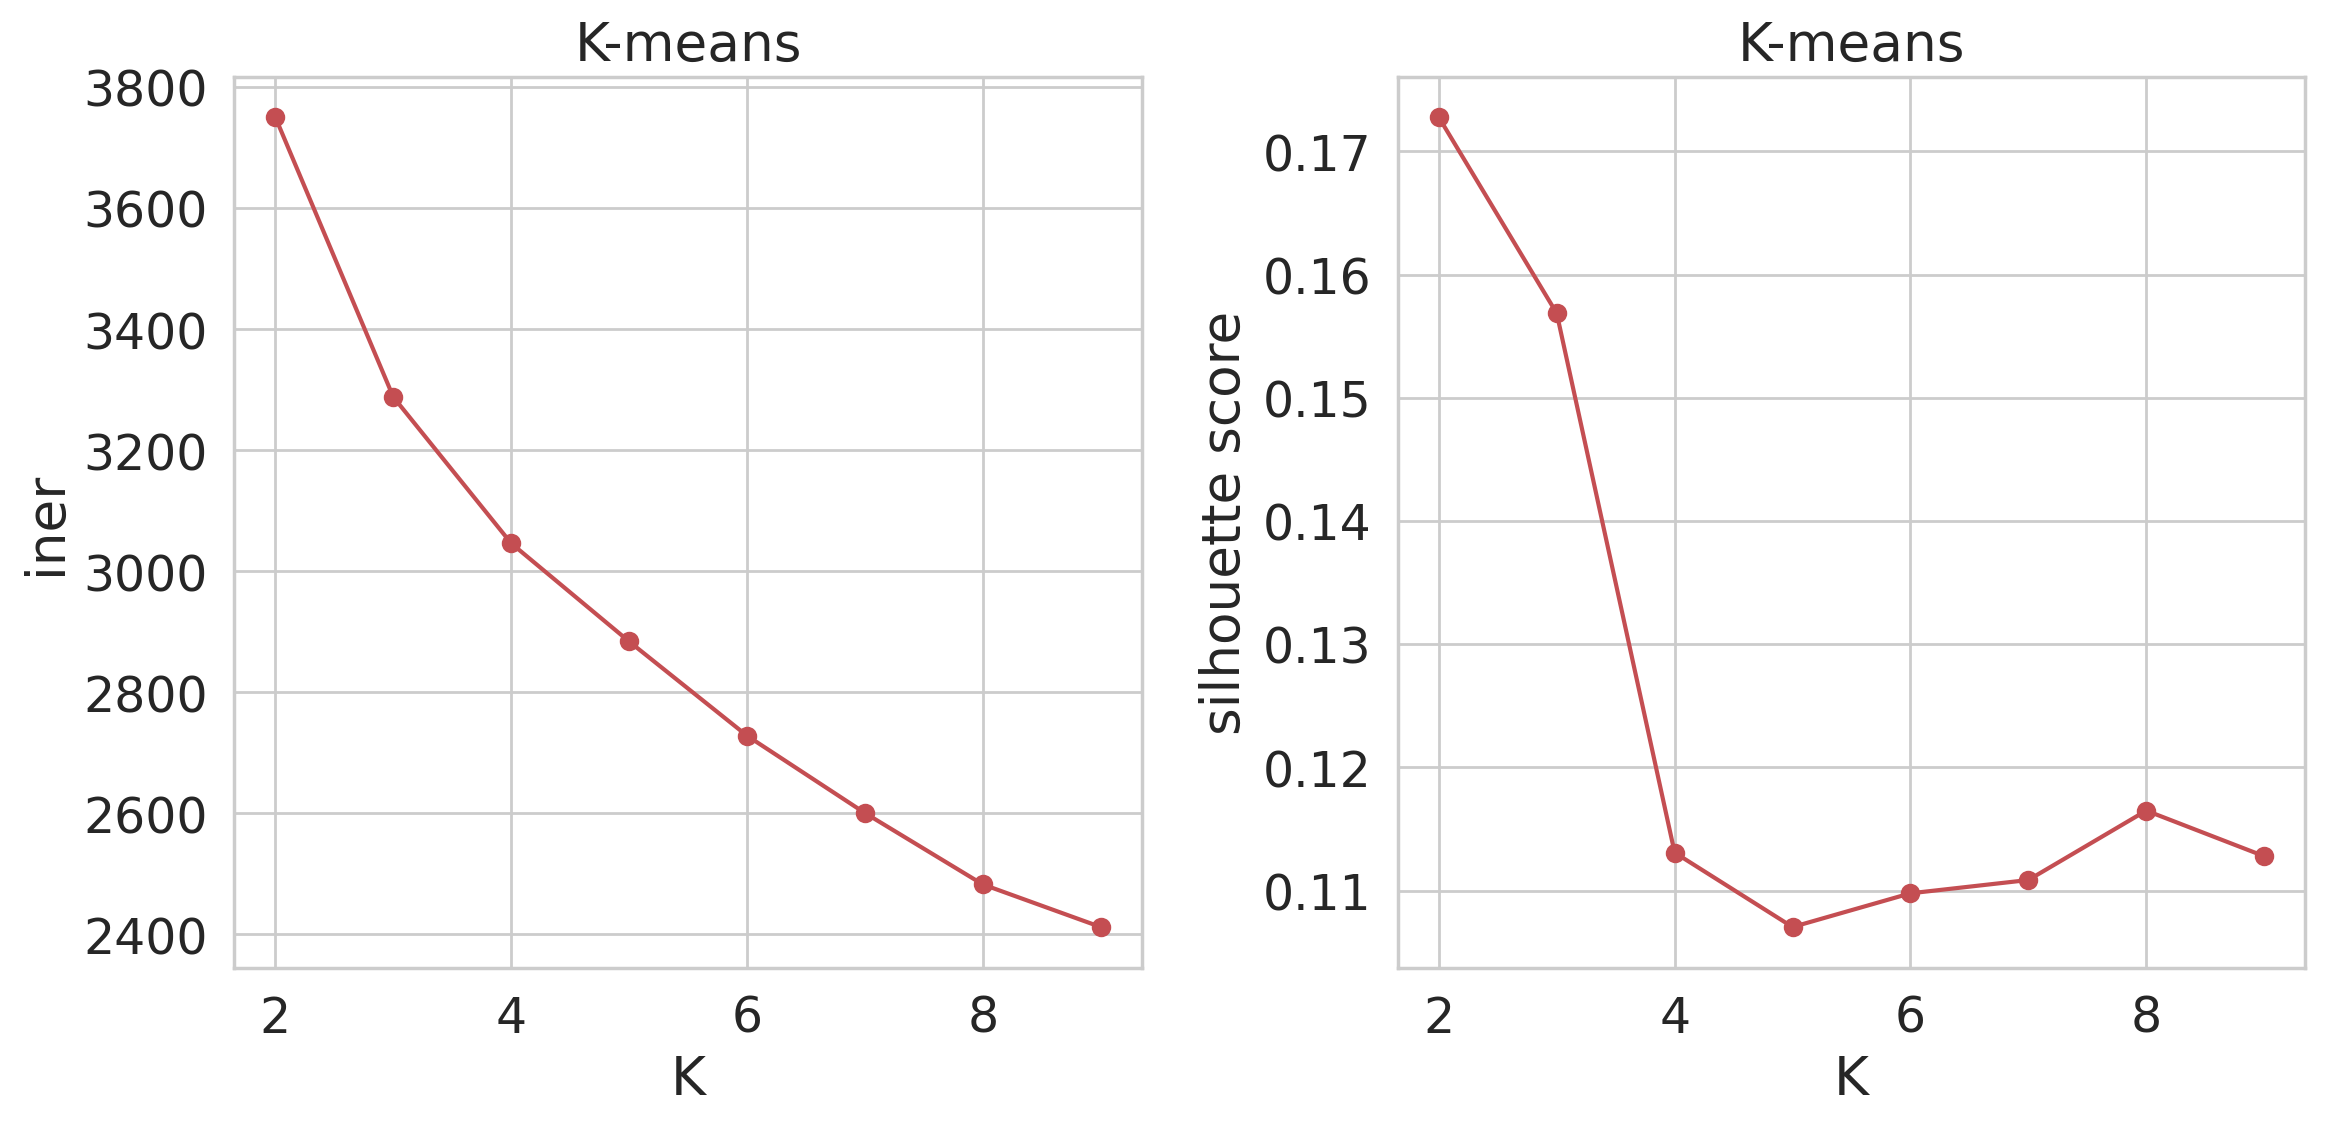

In [24]:
## 使用肘方法搜索合适的聚类数目
kmax = 10
K = np.arange(2,kmax)

iner = []
sil_scores = []
for ii in K:
    kmean = KMeans(n_clusters=ii,random_state=1)
    kmean.fit(df2SS)
    k_pre = kmean.fit_predict(df2SS)
    iner.append(kmean.inertia_) 
    sil_scores.append(silhouette_score(df2SS,k_pre))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(K,iner,"r-o")
plt.xlabel("K")
plt.ylabel("iner")
plt.title("K-means")
plt.subplot(1,2,2)
plt.plot(K,sil_scores,"r-o")
plt.xlabel("K")### 微信公众号：Adam大数据分析小站

plt.ylabel("silhouette score")
plt.title("K-means")
plt.tight_layout()
plt.show()

In [25]:
## 使用Kmeans将数据聚类维3个簇
kmean = KMeans(n_clusters=2,random_state=1)
k_pre = kmean.fit_predict(df2SS)
print("每簇包含的样本数量:",np.unique(k_pre,return_counts = True))


每簇包含的样本数量: (array([0, 1], dtype=int32), array([166, 193]))


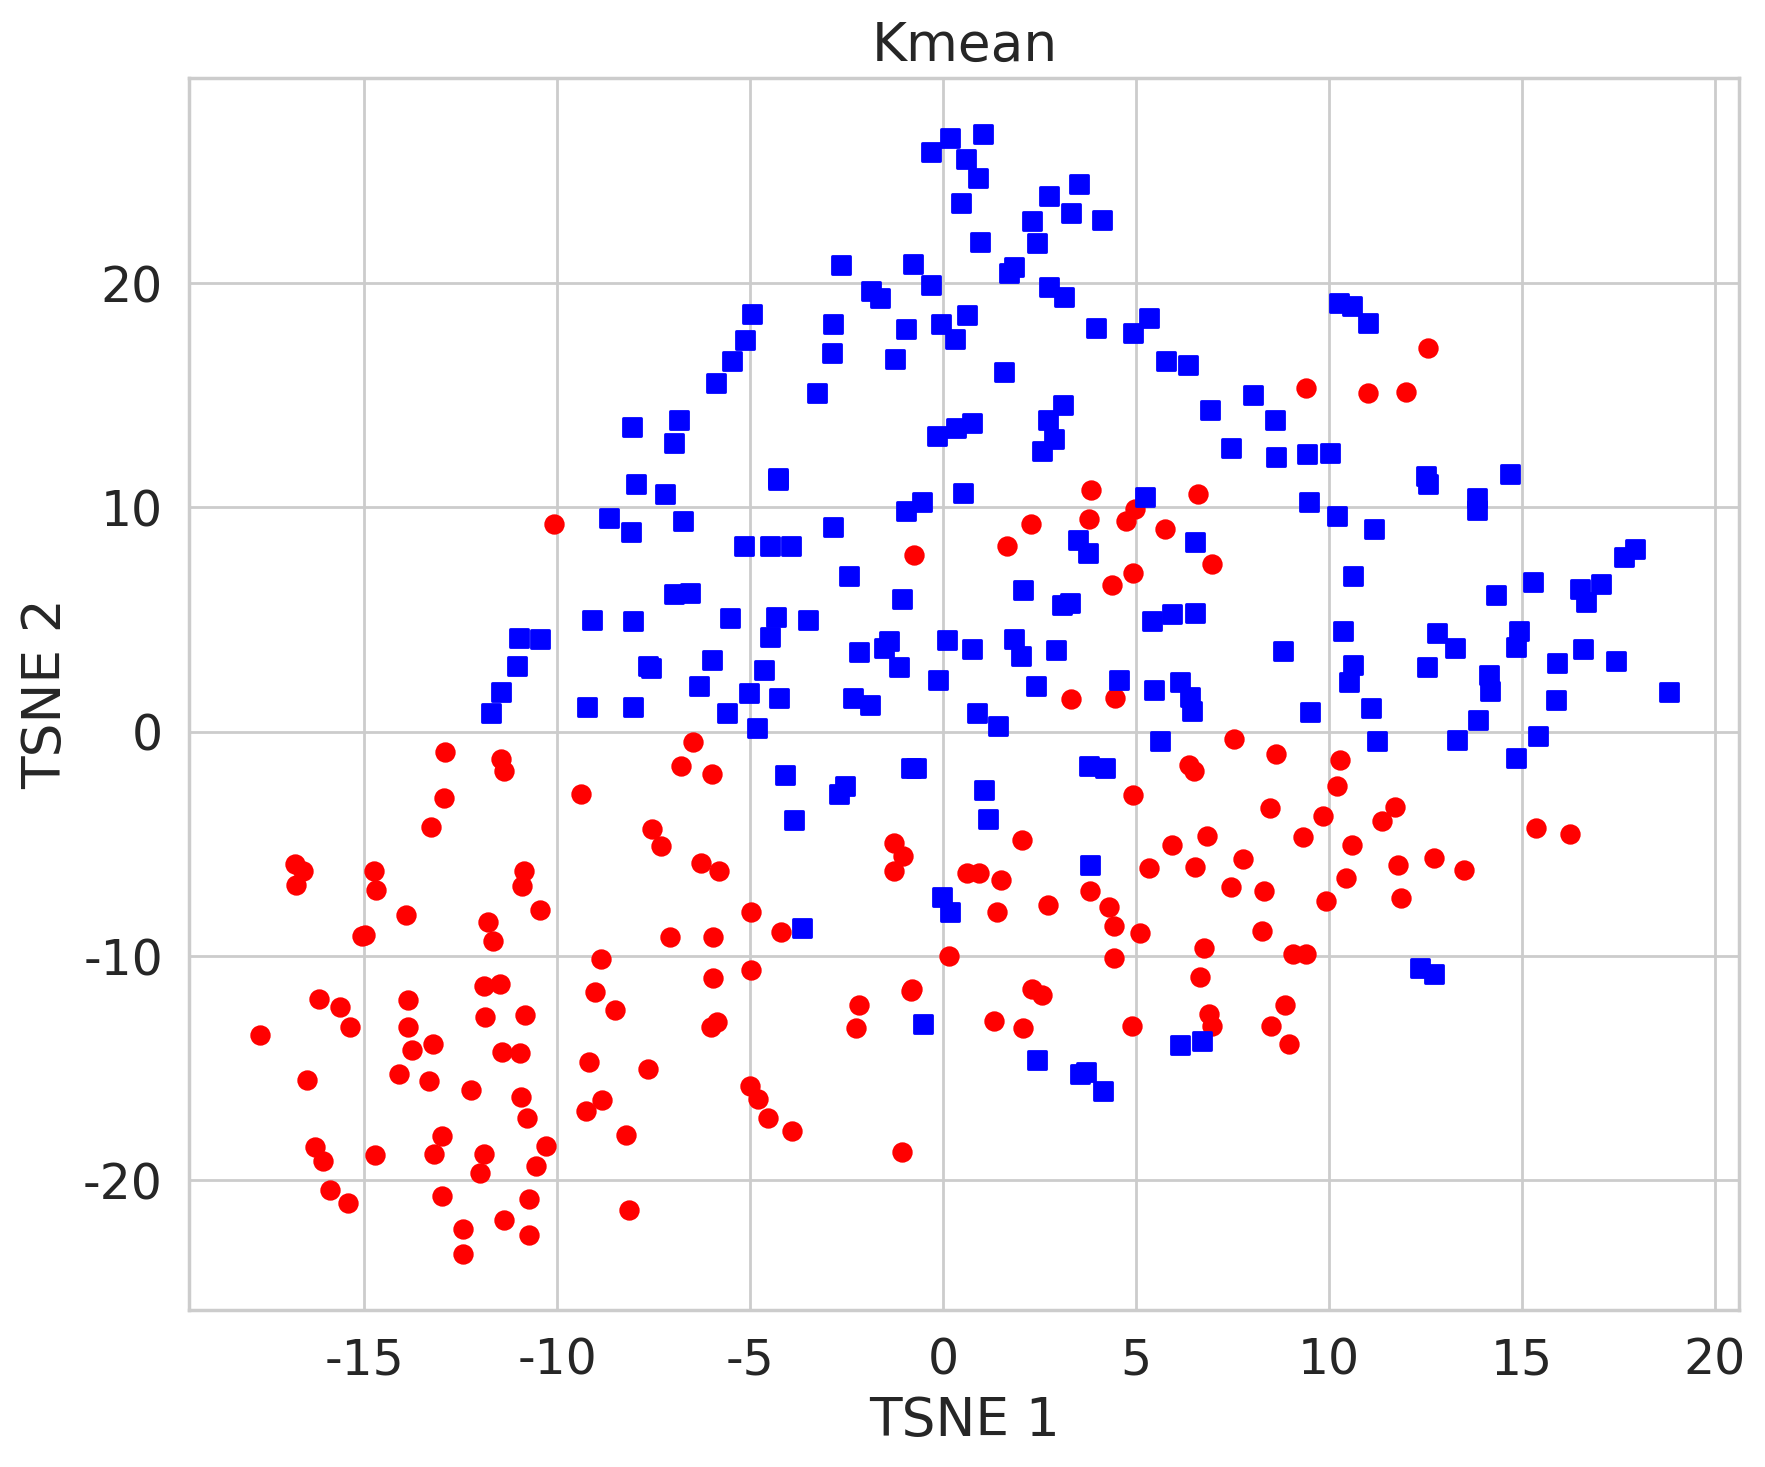

In [26]:
## 可视化（在tsne聚类的结果下可视化）
colors = ["red","blue","green"]
shapes = ["o","s","*"]
X = df2SS_tsne[:,0]
Y = df2SS_tsne[:,1]
k_pre
## 可视化
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1) 
for ii in np.unique(k_pre):
    index = k_pre == ii
    ax.scatter(X[index],Y[index],c = colors[ii],
               marker = shapes[ii],s = 40,alpha = 1)  
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.title("Kmean")
plt.show()

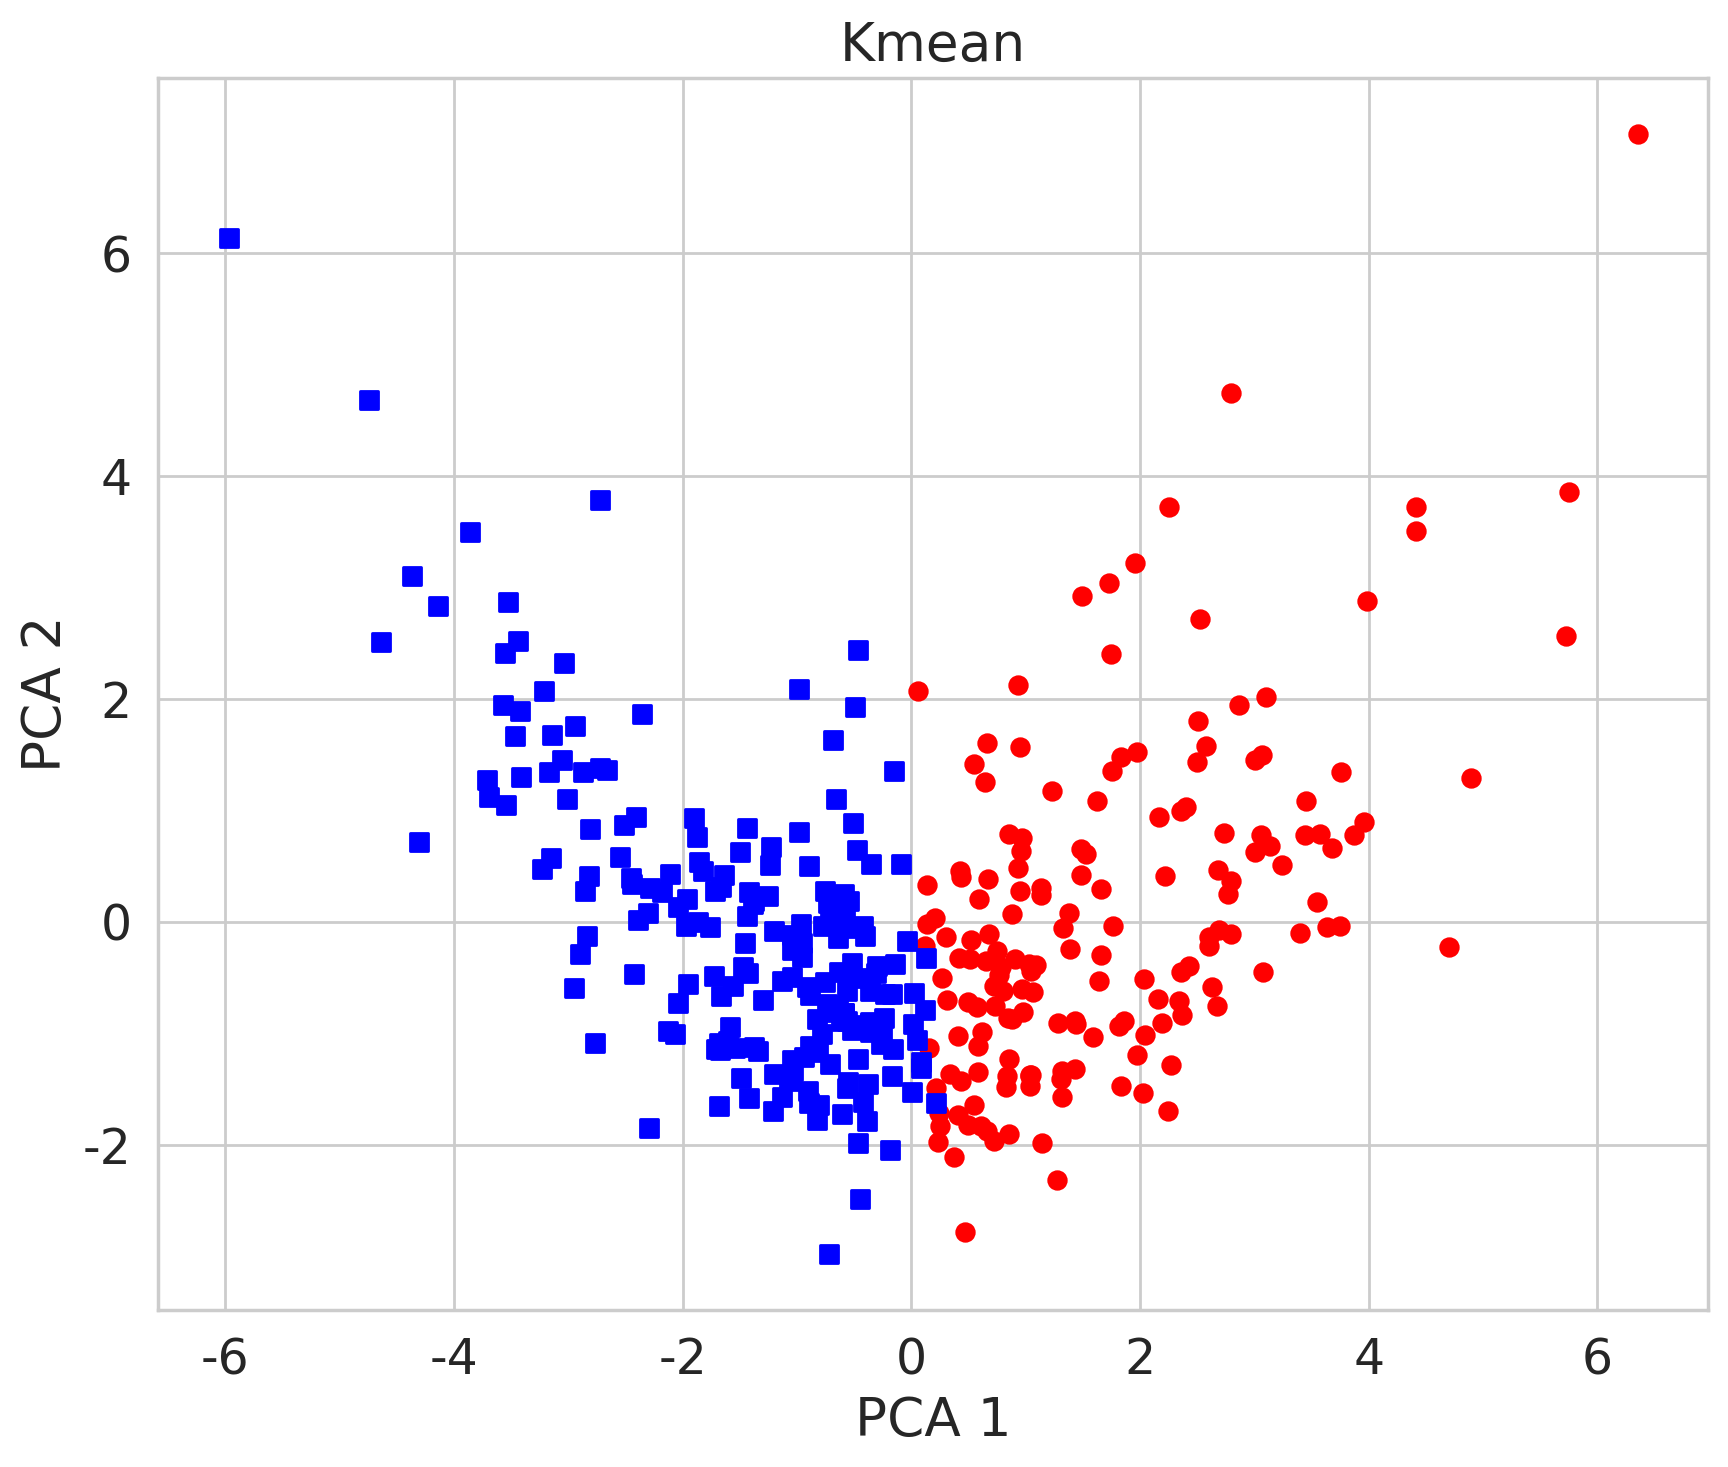

In [27]:
## 可视化（在PCA聚类的结果下可视化）
colors = ["red","blue","green"]
shapes = ["o","s","*"]
X = df2SS_pca[:,0]
Y = df2SS_pca[:,1]
k_pre
## 可视化
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1) 
for ii in np.unique(k_pre):
    index = k_pre == ii
    ax.scatter(X[index],Y[index],c = colors[ii],
               marker = shapes[ii],s = 40,alpha = 1)  
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.title("Kmean")
plt.show()

每簇包含的样本数量: (array([0, 1, 2], dtype=int32), array([199,  85,  75]))


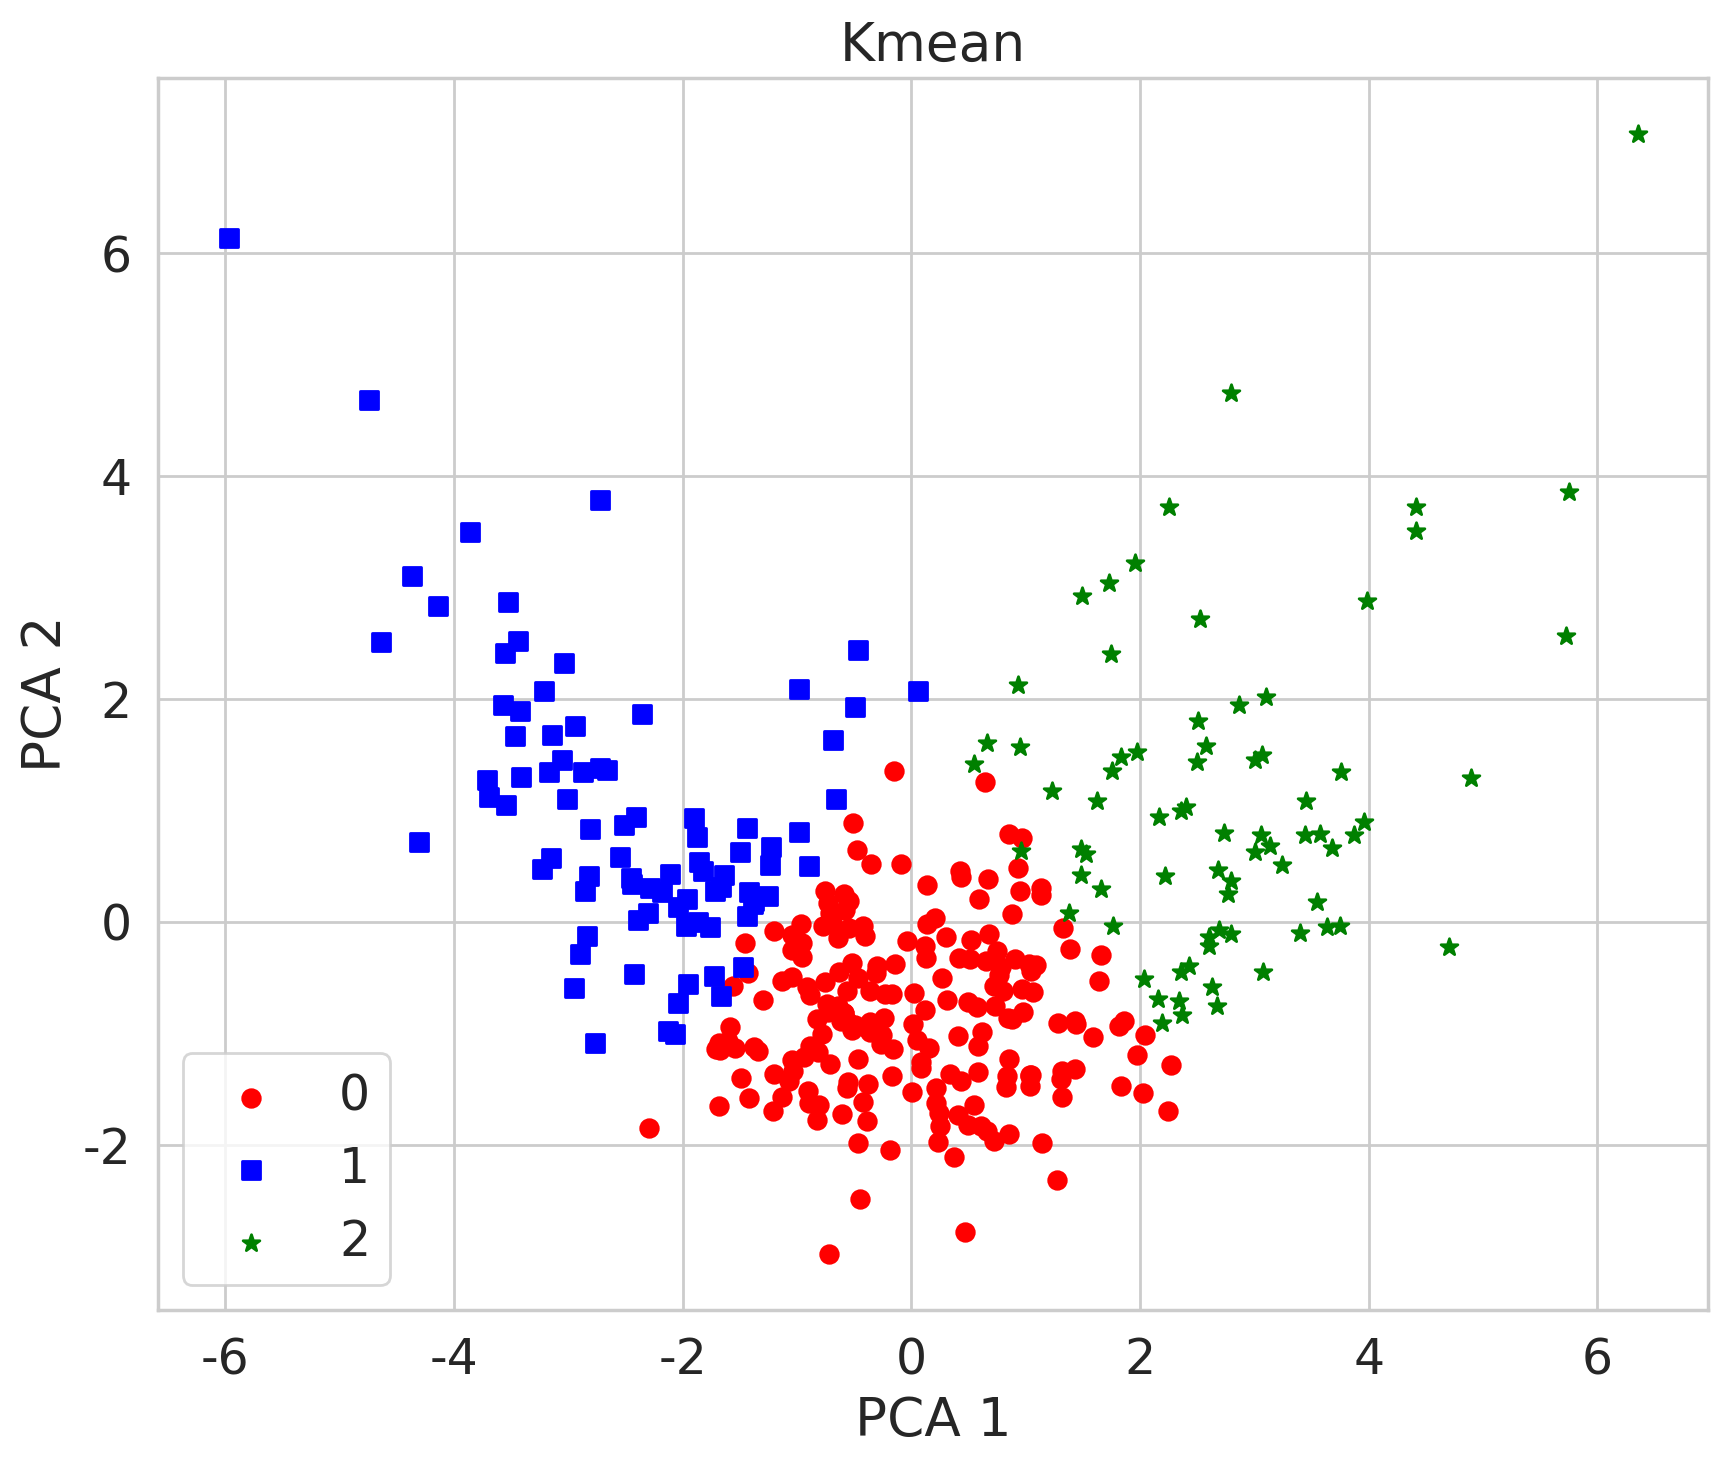

EERIE class: [0]


In [28]:
## 使用Kmeans将数据聚类维3个簇
kmean = KMeans(n_clusters=3,random_state=1)
k_pre = kmean.fit_predict(df2SS)
print("每簇包含的样本数量:",np.unique(k_pre,return_counts = True))
## 可视化（在tsne聚类的结果下可视化）
colors = ["red","blue","green"]
shapes = ["o","s","*"]
X = df2SS_pca[:,0]
Y = df2SS_pca[:,1]
k_pre
## 可视化
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1) 
for ii in np.unique(k_pre):
    index = k_pre == ii
    ax.scatter(X[index],Y[index],c = colors[ii],
               marker = shapes[ii],s = 40,alpha = 1,
               label = str(ii))
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.title("Kmean")
plt.legend()
plt.show()

## 预测出带测试数据的类别
X_test_pre = kmean.predict(X_test_SS)
print("EERIE class:",X_test_pre)

In [29]:
## 分析不同分组下的得分分布情况（以聚类为3类为例）
df3 = df[["tries1","tries2","tries3","tries4","tries5","tries6","triesX"]]
df3["class"] = k_pre
df3

,tries1,tries2,tries3,tries4,tries5,tries6,triesX,class
0,1,3,23,39,24,9,1,0
1,1,5,23,31,24,14,2,0
2,1,3,13,27,30,22,4,2
3,1,4,16,30,30,17,2,0
4,1,9,35,34,16,5,1,1
...,...,...,...,...,...,...,...,...
354,0,2,17,35,29,14,3,0
355,0,3,21,40,25,9,1,0
356,0,2,16,38,30,12,2,0
357,0,4,21,38,26,9,1,0


In [30]:
df3long = df3.melt(value_vars = ["tries1","tries2","tries3","tries4","tries5",
                                 "tries6","triesX"],
                   var_name="tries",value_name="value",id_vars=["class"])
df3long

,class,tries,value
0,0,tries1,1
1,0,tries1,1
2,2,tries1,1
3,0,tries1,1
4,1,tries1,1
...,...,...,...
2508,0,triesX,3
2509,0,triesX,1
2510,0,triesX,2
2511,0,triesX,1


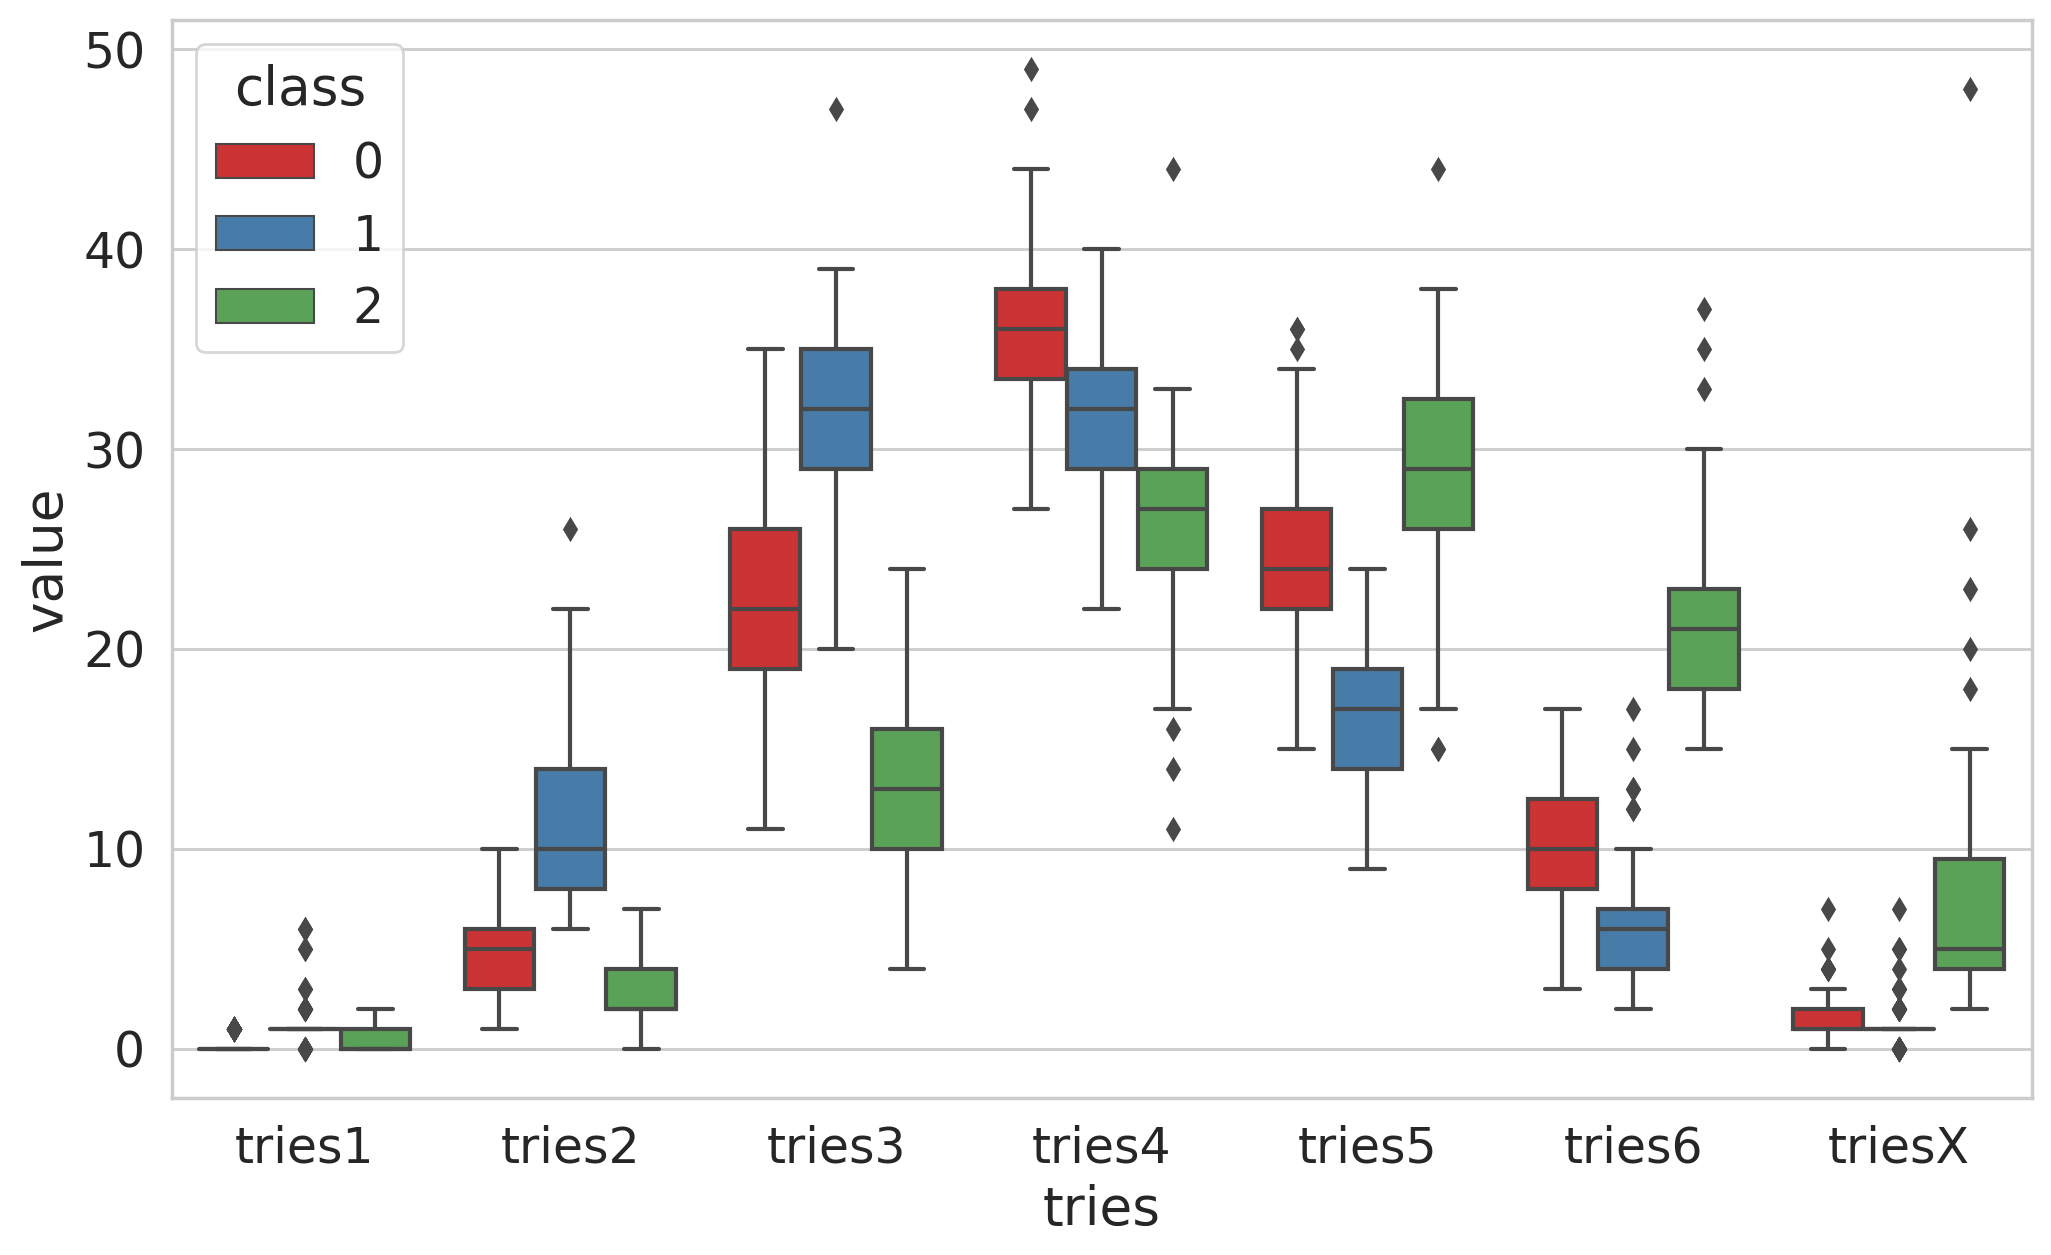

In [31]:
## 可视化不同分组下的数据得分情况
plt.figure(figsize=(12,7))
sns.boxplot(data=df3long,x="tries", y="value",hue="class",palette = "Set1")
plt.show()

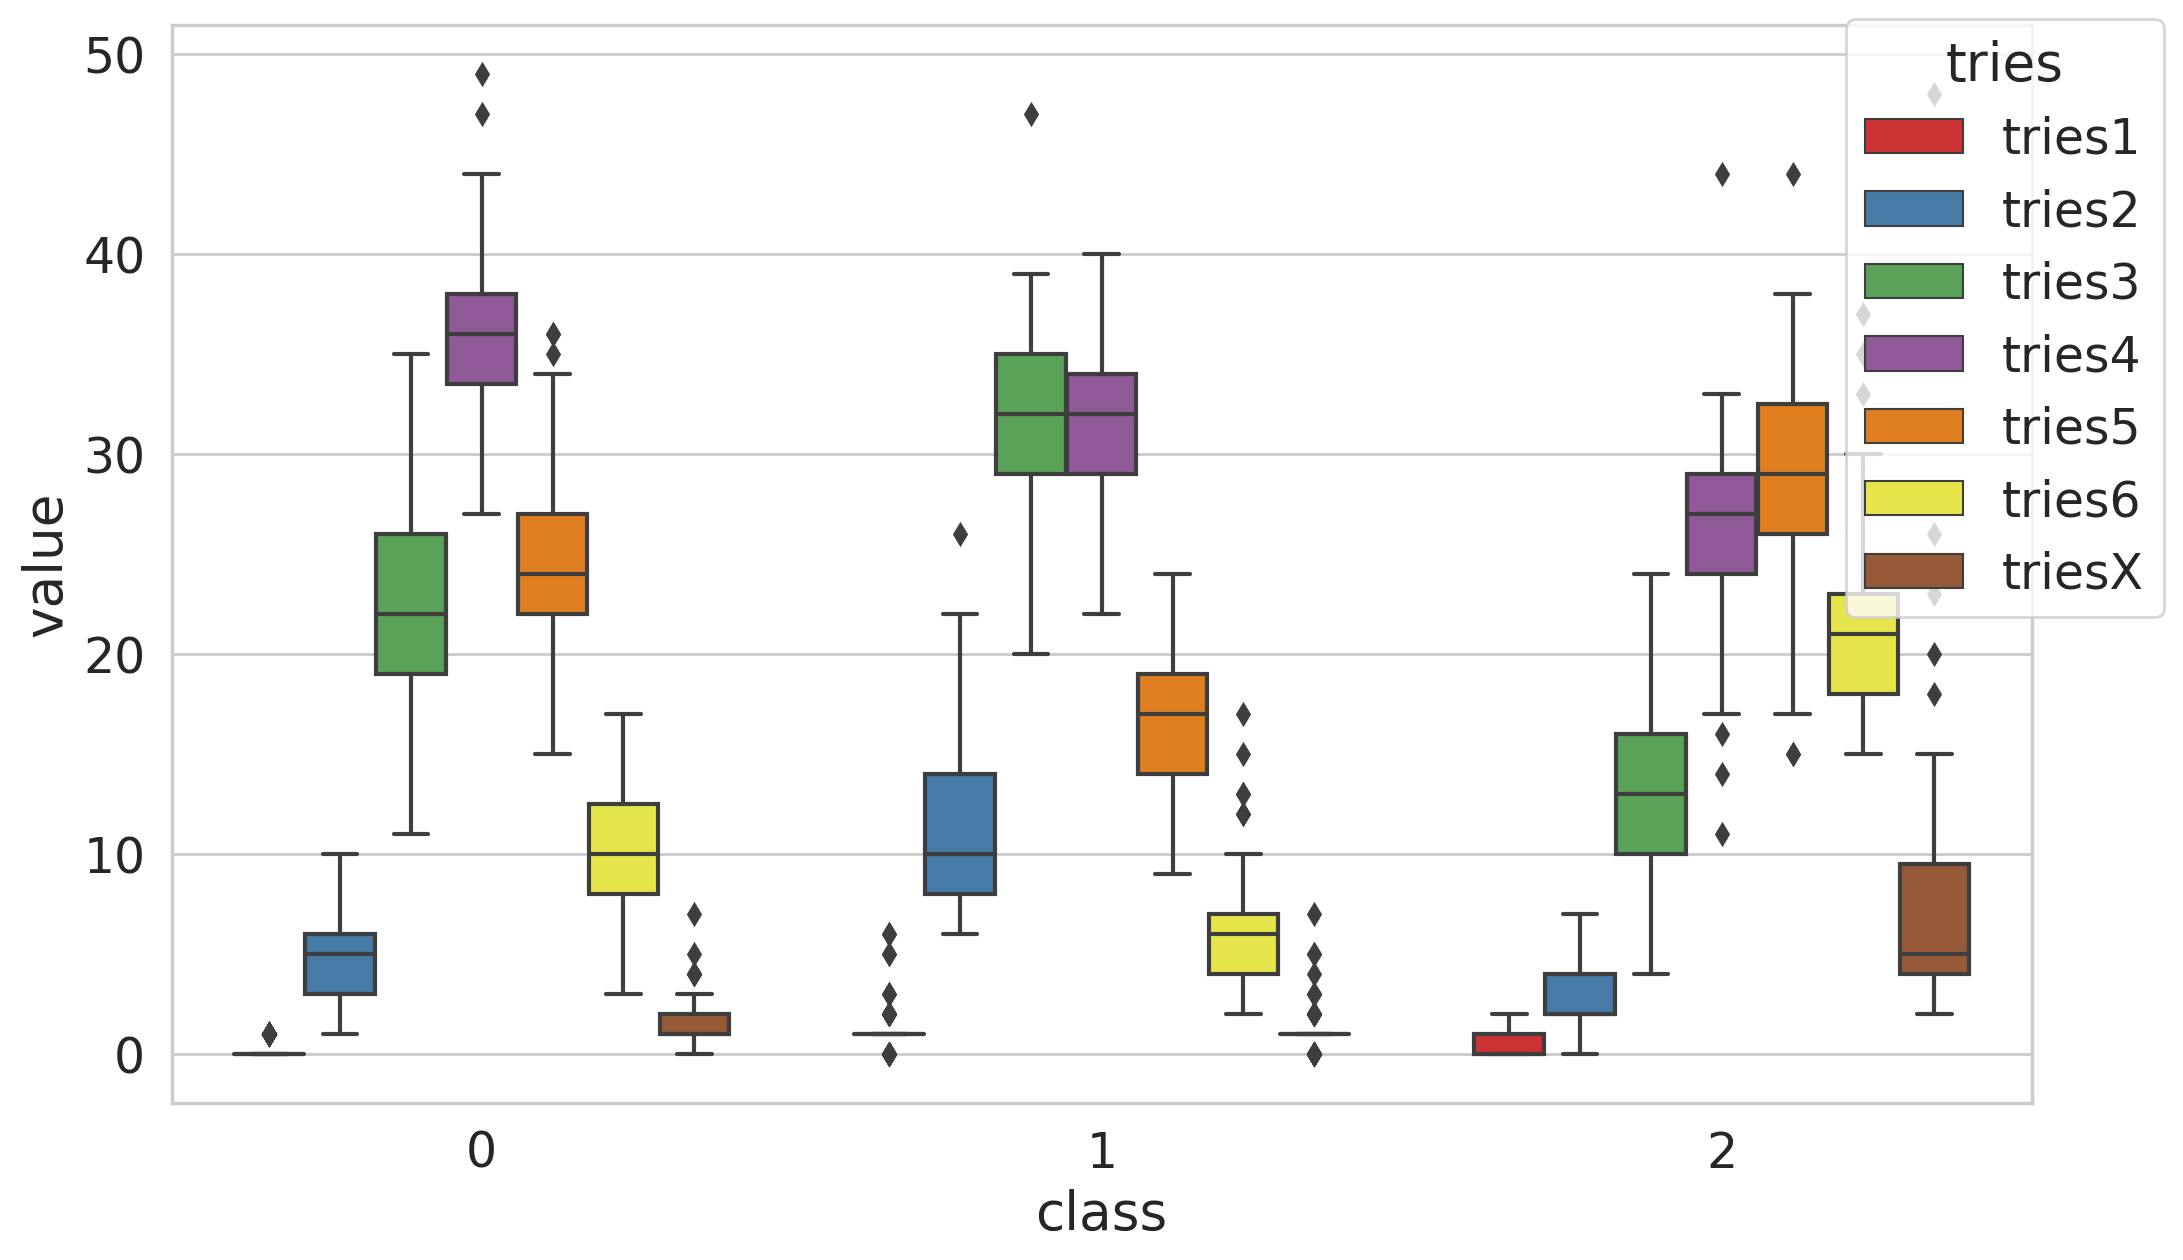

In [32]:
## 可视化不同分组下的数据得分情况
plt.figure(figsize=(12,7))
p = sns.boxplot(data=df3long,x="class", y="value",hue="tries",palette = "Set1")
sns.move_legend(p,loc = (0.9,0.45))
plt.show()

In [33]:
## 累计百分比
df4 = df[["tries1","tries2","tries3","tries4","tries5","tries6","triesX"]]
df4 = df4.cumsum(axis=1)
df4["class"] = k_pre
df4

,tries1,tries2,tries3,tries4,tries5,tries6,triesX,class
0,1,4,27,66,90,99,100,0
1,1,6,29,60,84,98,100,0
2,1,4,17,44,74,96,100,2
3,1,5,21,51,81,98,100,0
4,1,10,45,79,95,100,101,1
...,...,...,...,...,...,...,...,...
354,0,2,19,54,83,97,100,0
355,0,3,24,64,89,98,99,0
356,0,2,18,56,86,98,100,0
357,0,4,25,63,89,98,99,0


In [34]:
df4long = df4.melt(value_vars = ["tries1","tries2","tries3","tries4","tries5",
                                 "tries6","triesX"],
                   var_name="tries",value_name="value",id_vars=["class"])
df4long

,class,tries,value
0,0,tries1,1
1,0,tries1,1
2,2,tries1,1
3,0,tries1,1
4,1,tries1,1
...,...,...,...
2508,0,triesX,100
2509,0,triesX,99
2510,0,triesX,100
2511,0,triesX,99


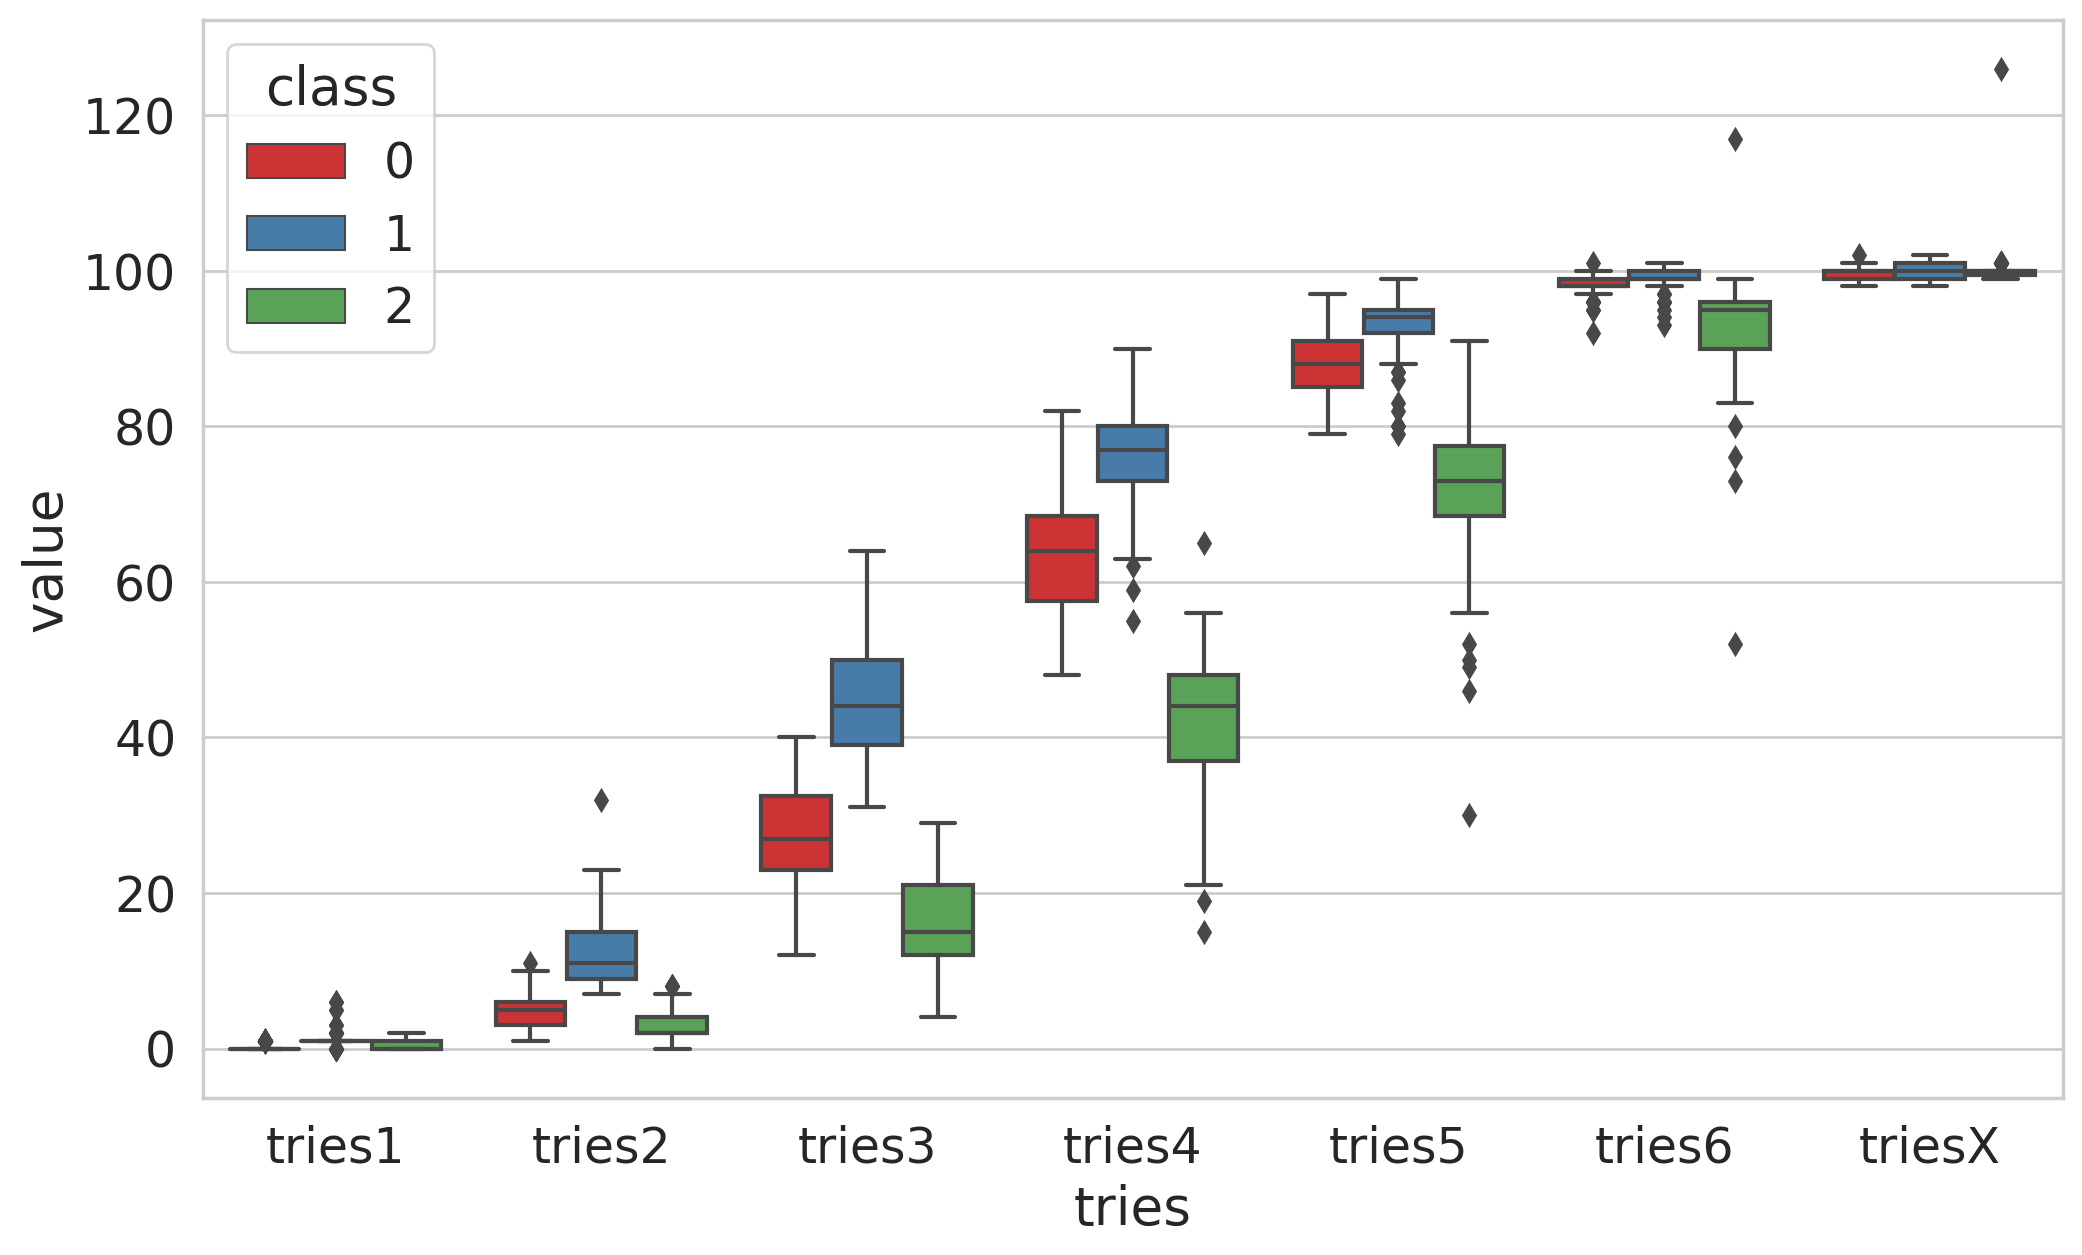

In [35]:
## 可视化不同分组下的数据得分情况
plt.figure(figsize=(12,7))
sns.boxplot(data=df4long,x="tries", y="value",hue="class",palette = "Set1")
plt.show()

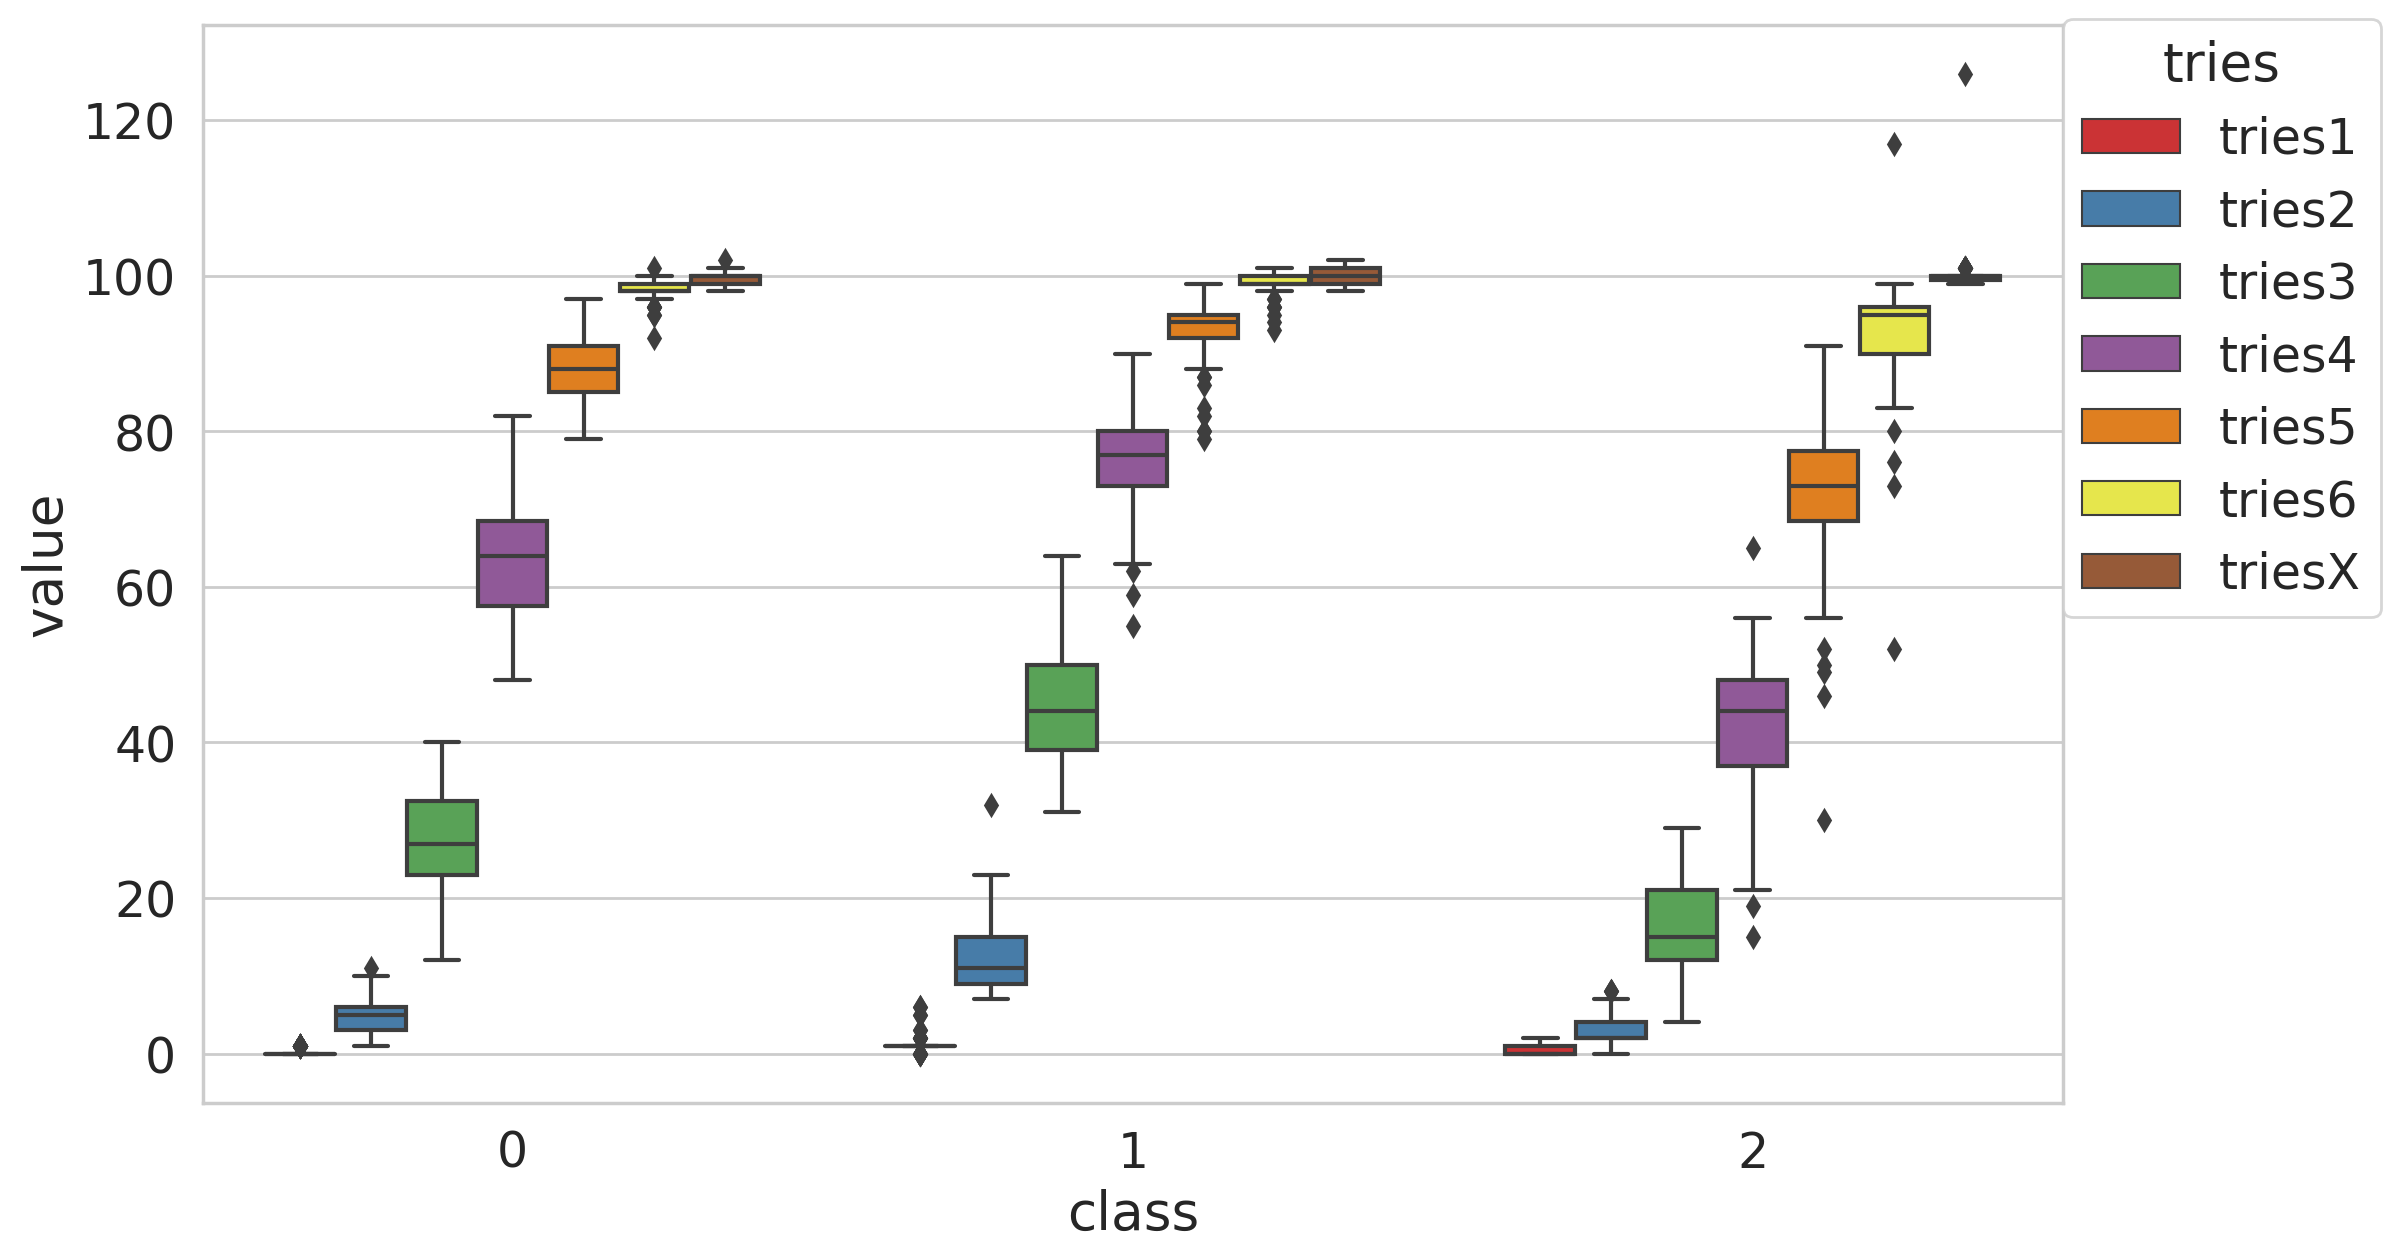

In [36]:
## 可视化不同分组下的数据得分情况
plt.figure(figsize=(12,7))
p = sns.boxplot(data=df4long,x="class", y="value",hue="tries",palette = "Set1")
sns.move_legend(p,loc = (1,0.45))
plt.show()

## 根据累计正确率，可以将0-2三个簇进行归类，困难，正常，简单
## 0:正常;  1:困难;   2: 简单;

## 所以待预测的词语难度可以认为是正常